# SHAP Explainability for the Fraud & Credit Card Dataset

---
## What is SHAP?

SHAP is based on **Shapley values** from cooperative game theory. The core idea:

**Analogy**: Imagine a team of players (features) working together to win a game (make a prediction).
- The "game" is making a prediction
- The "players" are the feature values for a specific data point
- The "payout" is the model's prediction
- **SHAP values** fairly distribute the "payout" among all "players"

## The Key Formula

```
model_output = base_value + sum(SHAP_values)
```

- **Base value**: The average model output across all training data (the "starting point")
- **SHAP values**: Each feature's contribution (positive or negative) to push the prediction away from the base value

## SHAP Properties
1. **Additivity**: SHAP values sum up to the difference between prediction and base value
2. **Consistency**: If a feature's contribution increases, its SHAP value won't decrease
3. **Local Accuracy**: The explanation matches the actual prediction exactly

## Fraud Dataset

Importing libraries

In [1]:
import joblib
import pandas as pd
import sys
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
import matplotlib.pyplot as plt
import numpy as np
import shap
from scripts.data_loader import load_data

/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/week5_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the trained model

In [2]:
# Load trained model
ensemble_model = joblib.load("/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/models/Fraud/xgboost.pkl")
baseline_model = joblib.load("/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/models/Fraud/logistic_regression.pkl")
# Load feature names
feature_names = joblib.load("/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/models/Fraud/fraud_feature_names.pkl")

Print the number of features and the feature names

In [3]:
print(len(feature_names))
print(feature_names[:])

42
['num__hour_of_day', 'num__time_since_signup_days', 'cat__browser_Chrome', 'cat__browser_FireFox', 'cat__browser_IE', 'cat__browser_Opera', 'cat__browser_Safari', 'cat__source_Ads', 'cat__source_Direct', 'cat__source_SEO', 'cat__sex_F', 'cat__sex_M', 'cat__day_of_week_Friday', 'cat__day_of_week_Monday', 'cat__day_of_week_Saturday', 'cat__day_of_week_Sunday', 'cat__day_of_week_Thursday', 'cat__day_of_week_Tuesday', 'cat__day_of_week_Wednesday', 'cat__country_Australia', 'cat__country_Brazil', 'cat__country_Canada', 'cat__country_China', 'cat__country_France', 'cat__country_Germany', 'cat__country_India', 'cat__country_Italy', 'cat__country_Japan', 'cat__country_Korea Republic of', 'cat__country_Mexico', 'cat__country_Netherlands', 'cat__country_Other', 'cat__country_Russian Federation', 'cat__country_South Africa', 'cat__country_Spain', 'cat__country_Sweden', 'cat__country_Switzerland', 'cat__country_Taiwan; Republic of China (ROC)', 'cat__country_United Kingdom', 'cat__country_Unite

Loading the test data

In [4]:
test_df = load_data("/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/data/processed/fraud_preprocessed_test.csv")

In [5]:
# Prepare test data
X_test = test_df[feature_names]

y_test = test_df["class"] 

Top 10 Feature Importances from XGBoost Model

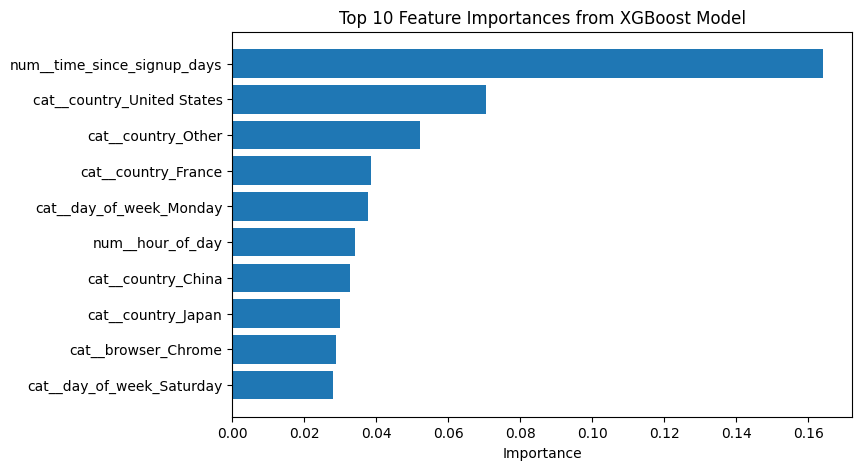

In [6]:
importances = ensemble_model.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Top 10
top10 = fi_df.head(10)

plt.figure(figsize=(8,5))
plt.barh(top10["feature"], top10["importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances from XGBoost Model")
plt.xlabel("Importance")
plt.show()

- The feature importance reveals that the time since account creation (`num_time_since_signup_days`) is the strongest predictor of fraud, likely indicating newer accounts are riskier. Geographic features, particularly the United States and an "Other" category, are highly influential, suggesting fraud patterns are region-specific. Interestingly, specific weekdays and the hour of day also rank highly, pointing to temporal fraud trends. Browser type and country flags round out the list, showing that both user behavior and demographic signals contribute to the model's decisions.

Top 10 Feature Importances from Logistic Regression Model

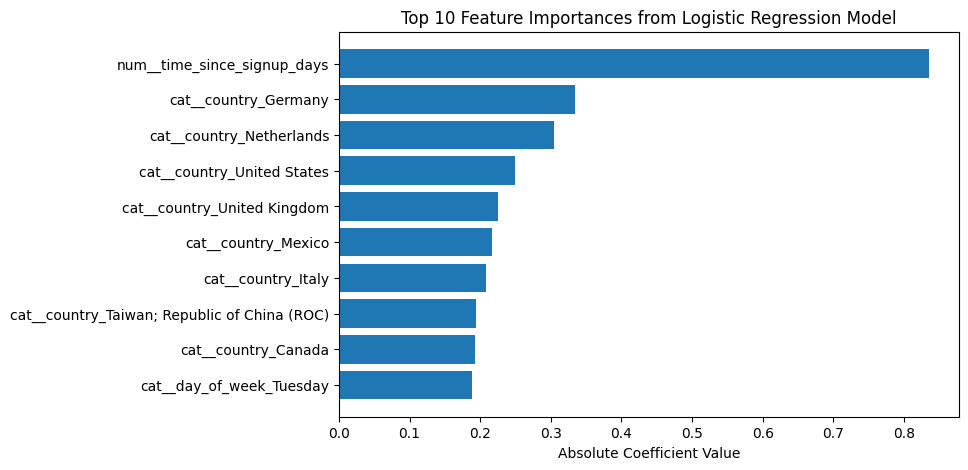

In [7]:
# coef_ is (n_classes, n_features) for binary classification
coefs = baseline_model.coef_[0]  # take first row for binary classification

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": np.abs(coefs)  # absolute value to see magnitude
}).sort_values(by="importance", ascending=False)

# Top 10
top10 = fi_df.head(10)

plt.figure(figsize=(8,5))
plt.barh(top10["feature"], top10["importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances from Logistic Regression Model")
plt.xlabel("Absolute Coefficient Value")
plt.show()

- The Logistic Regression model also identifies num_time_since_signup_days as the most critical feature, confirming that newer accounts present the highest fraud risk across both models. However, its feature importance is overwhelmingly dominated by country indicators, with eight of the top ten features being specific nationalities, suggesting a strong geographic bias in its linear decision boundary. The scale of the coefficients is much larger than in XGBoost's importance scores, which is a characteristic difference in how the models quantify influence. The presence of a specific weekday (Tuesday) further supports the role of transaction timing in fraud patterns, aligning with the XGBoost findings.

SHAP Explanation for Model Predictions

In [8]:
explainer = shap.TreeExplainer(ensemble_model)
shap_values = explainer(X_test)

Visualization

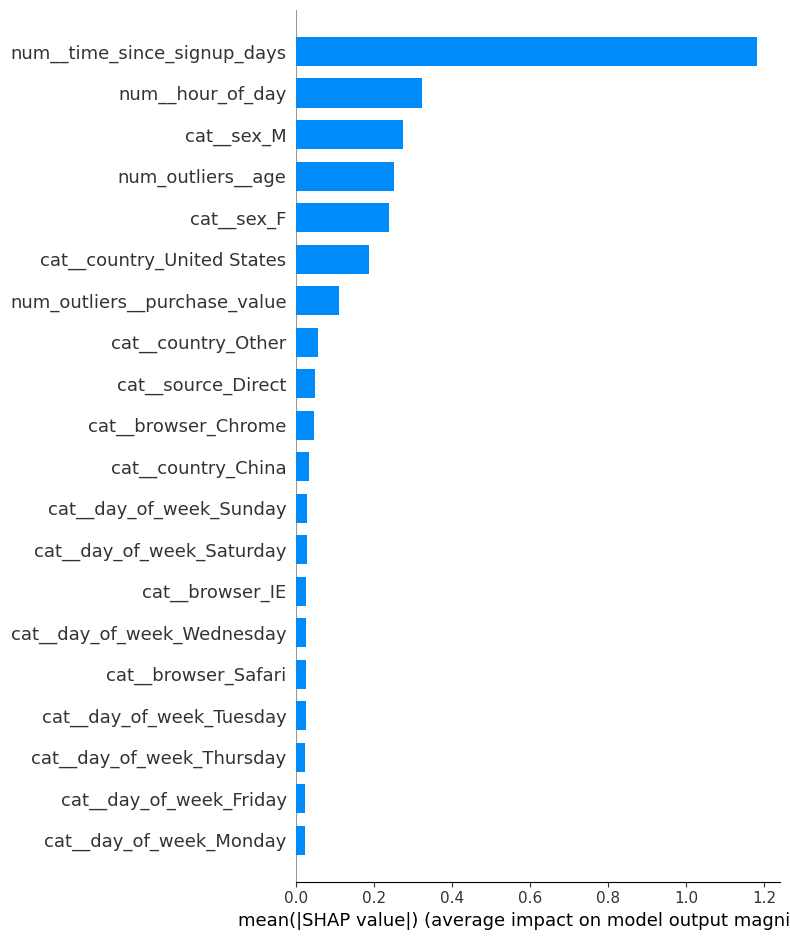

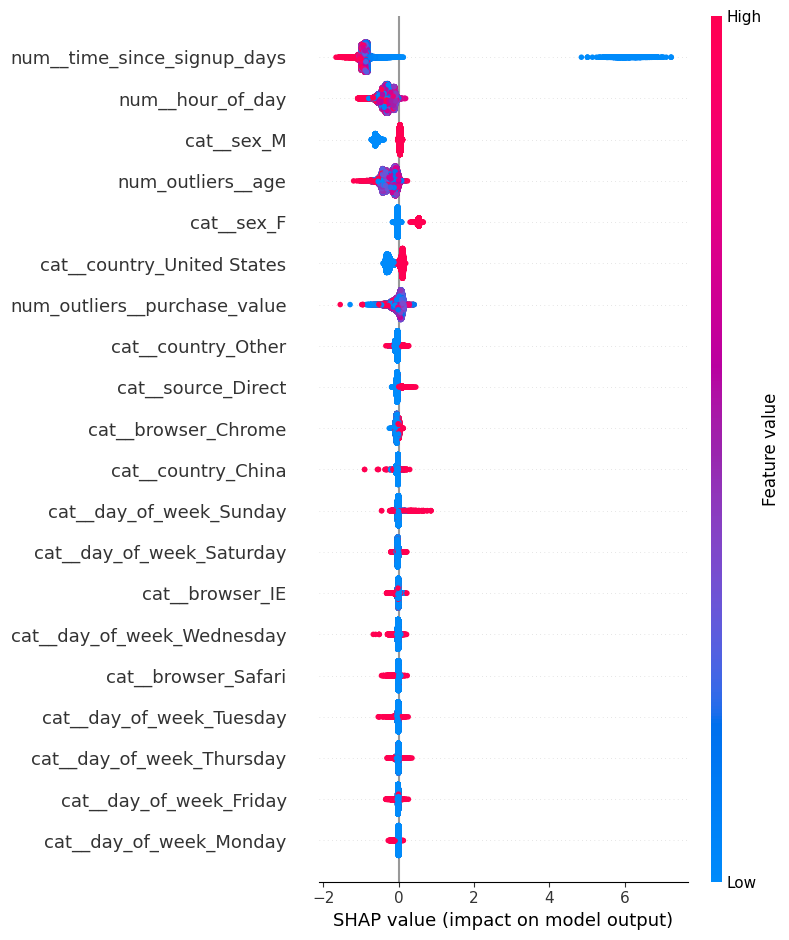

In [9]:
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

- This SHAP summary plot reveals the nuanced drivers of the fraud model's predictions. The num_time_since_signup_days feature has the widest spread, where very low values (new accounts) push predictions strongly toward fraud (positive SHAP values). A high num_hour_of_day also increases fraud risk, indicating suspicious activity during late hours. Interestingly, being male (cat_sex_M) has a mixed but overall positive impact on fraud prediction compared to female, while high outlier counts in age and purchase value are clear risk factors. This visual confirms that fraud is primarily associated with new accounts, unusual transaction times, and anomalous user characteristics.

Predicting Fraud on the Test Set

In [10]:
y_pred = ensemble_model.predict(X_test)


Identifying True Positives, False Positives, and False Negatives

In [11]:
# True positives (fraud correctly predicted)
tp_idx = np.where((y_test==1) & (y_pred==1))[0][0]

# False positives (legit flagged as fraud)
fp_idx = np.where((y_test==0) & (y_pred==1))[0][0]

# False negatives (fraud missed)
fn_idx = np.where((y_test==1) & (y_pred==0))[0][0]


### SHAP Force Plot for a True Positive, False Positive and False Negative

In [12]:
# For Jupyter Notebook
shap.initjs()

# True positive
shap.force_plot(explainer.expected_value, shap_values[tp_idx].values, X_test.iloc[tp_idx])


- This true positive case shows the model correctly flagged fraud where the account was very new (num_time_since_signup_days = -1.574), which is the primary high-risk signal. The transaction also occurred at a moderately late hour (num_hour_of_day = 0.216), supporting the fraud decision with a secondary temporal risk factor.

In [13]:
# False positive
shap.force_plot(explainer.expected_value, shap_values[fp_idx].values, X_test.iloc[fp_idx])

- This false positive was likely triggered because the account was very new (-1.571), which strongly pushes the model toward a fraud prediction. The fact the user is female (cat_sex_F = 1) and using Safari may have been insufficient contextual evidence to override the high-risk signal from the account age.

In [14]:
# False negative
shap.force_plot(explainer.expected_value, shap_values[fn_idx].values, X_test.iloc[fn_idx])

- This false negative case shows an account with moderately recent activity (-0.9301) and a low age outlier score, which likely caused the model to underestimate the risk. The combination of being female and the lack of other strong high-risk flags allowed this fraudulent transaction to be incorrectly classified as legitimate.

Mean absolute SHAP value per feature

In [15]:
# Mean absolute SHAP value per feature
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='shap_importance', ascending=False)

top5_shap = shap_importance.head(5)
print("Top 5 SHAP features driving fraud predictions:")
print(top5_shap)

Top 5 SHAP features driving fraud predictions:
                        feature  shap_importance
1   num__time_since_signup_days         1.181597
0              num__hour_of_day         0.321781
11                   cat__sex_M         0.273059
41            num_outliers__age         0.250934
10                   cat__sex_F         0.236410


Top 5 Built-in Feature Importance

In [16]:
top5_builtin = fi_df.head(5)
print("Top 5 built-in feature importance:")
print(top5_builtin)

Top 5 built-in feature importance:
                        feature  importance
1   num__time_since_signup_days    0.836098
24         cat__country_Germany    0.333810
30     cat__country_Netherlands    0.304873
39   cat__country_United States    0.249032
38  cat__country_United Kingdom    0.224836


- Comparing SHAP and built-in importance reveals a core alignment on the primary risk driver: num_time_since_signup_days is the top feature in both, confirming new accounts as the strongest fraud signal.

- However, SHAP highlights behavioral and temporal drivers (hour of day, user sex, age outliers), while built-in importance is dominated by geographic features (specific countries). This suggests the model uses location for broad segmentation, but individual fraud decisions are more influenced by real-time user activity and account characteristics.

- A surprising finding is the high SHAP importance for user sex (both M and F), indicating it is a meaningful, non-intuitive risk differentiator that built-in importance completely overlooks.

- This divergence shows that built-in importance reflects which features split the data globally, whereas SHAP reveals what actually pushes predictions for individual cases, offering a more nuanced, causality-focused view of fraud drivers.



#### SHAP Dependence Plots for Top Features vs. Multiple Interaction Features

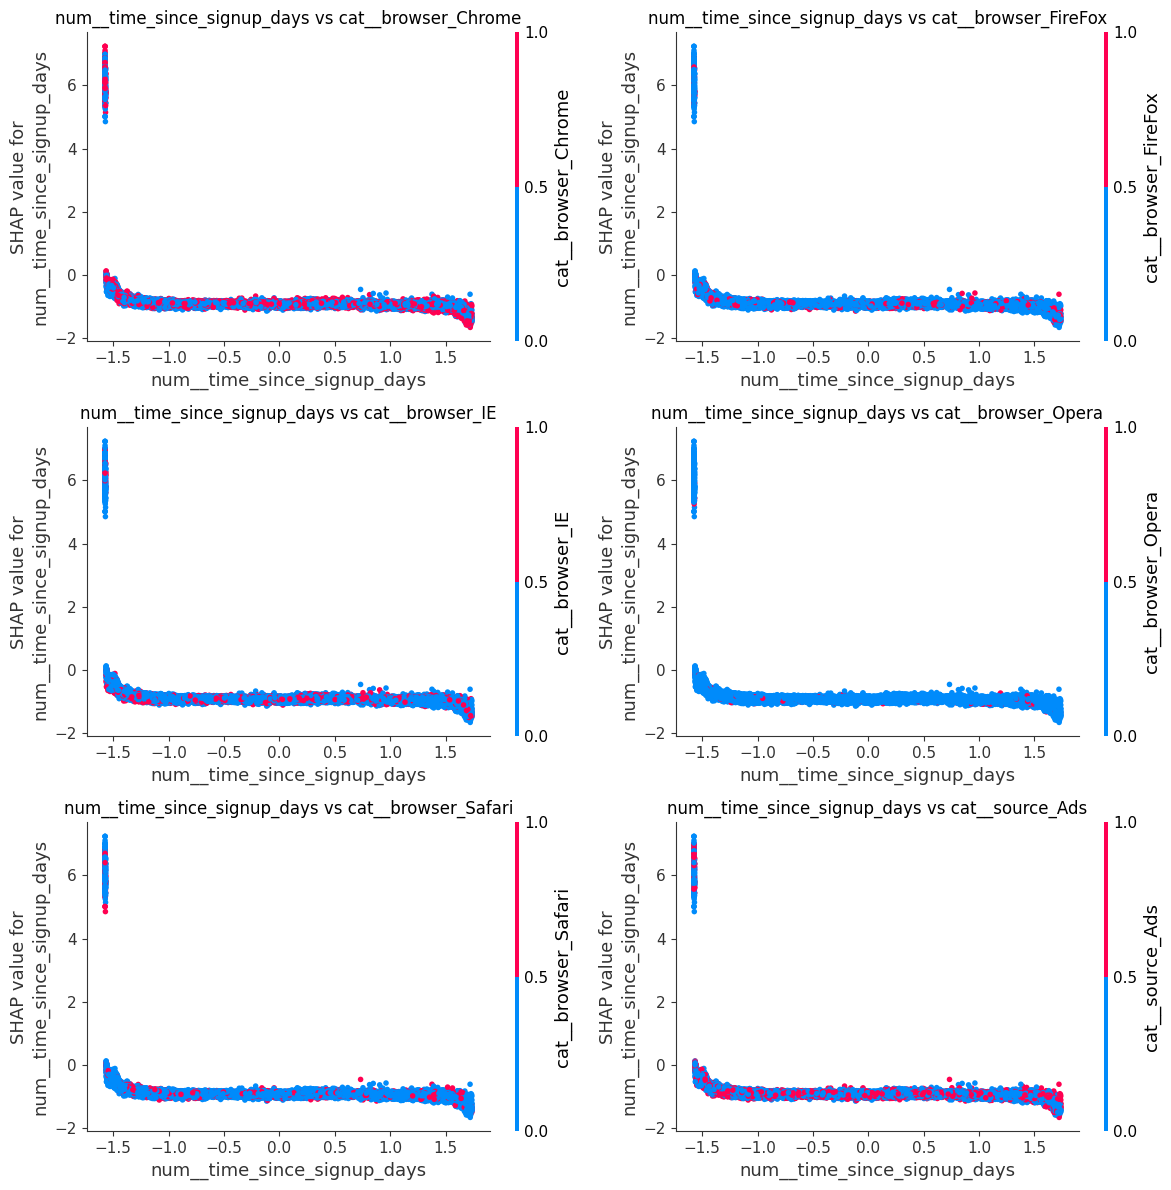

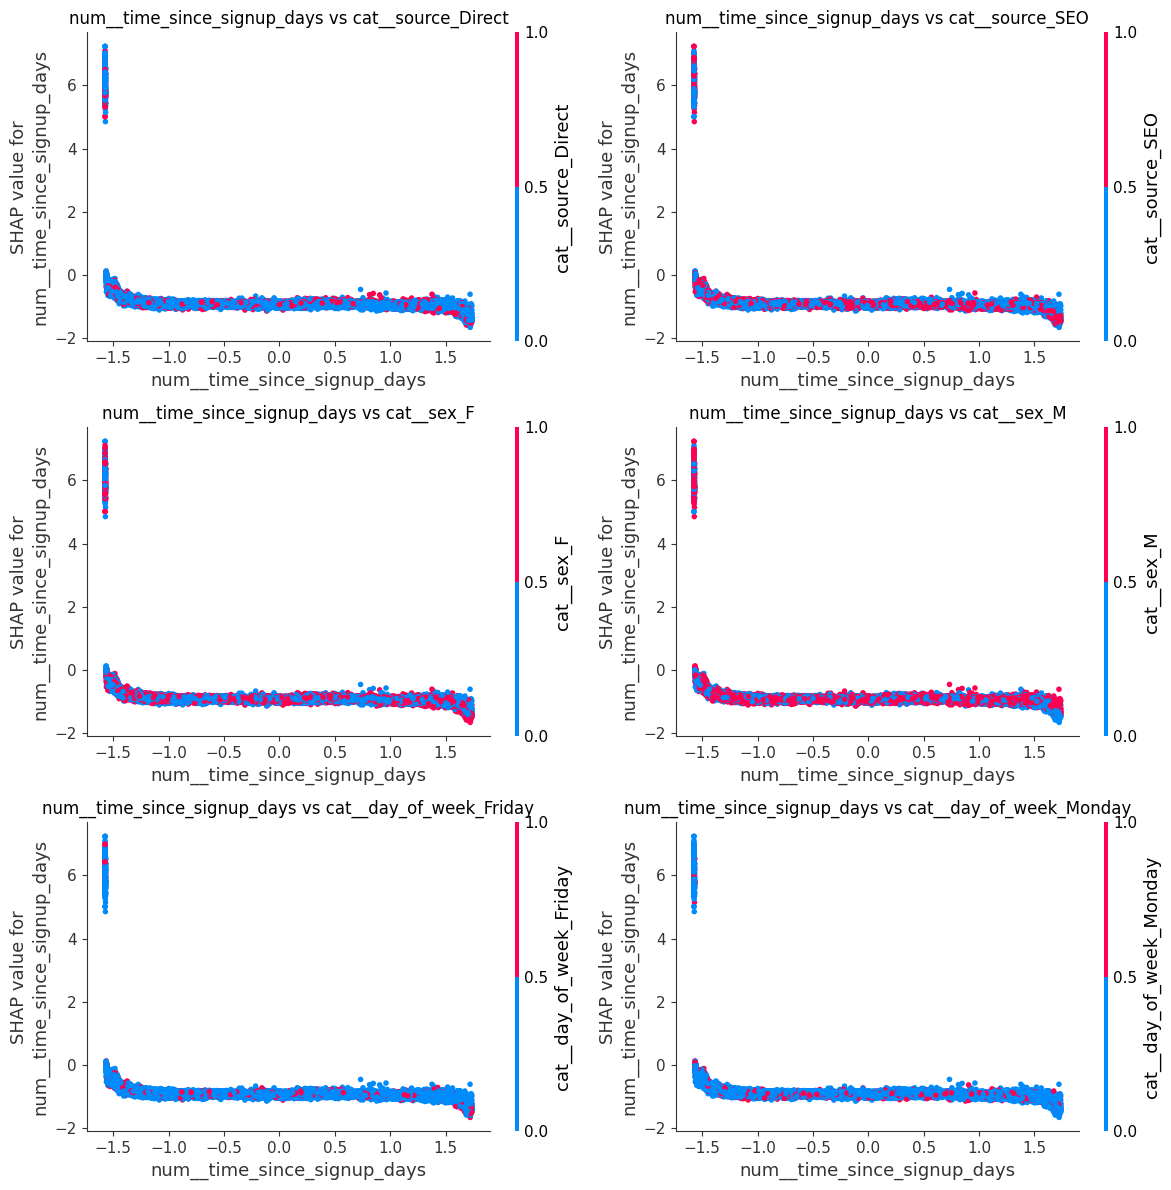

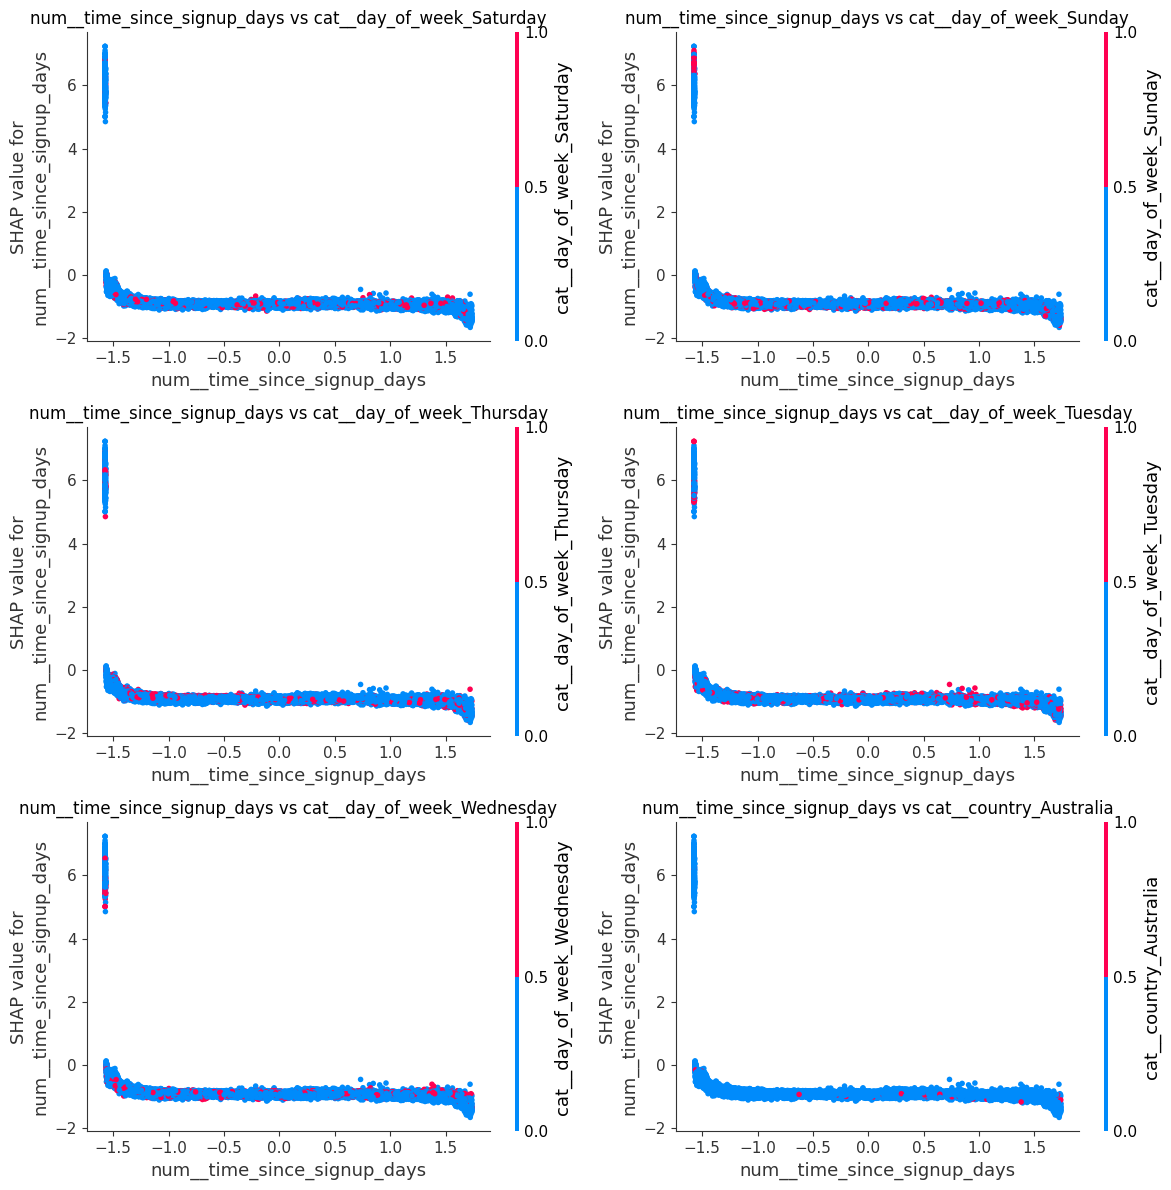

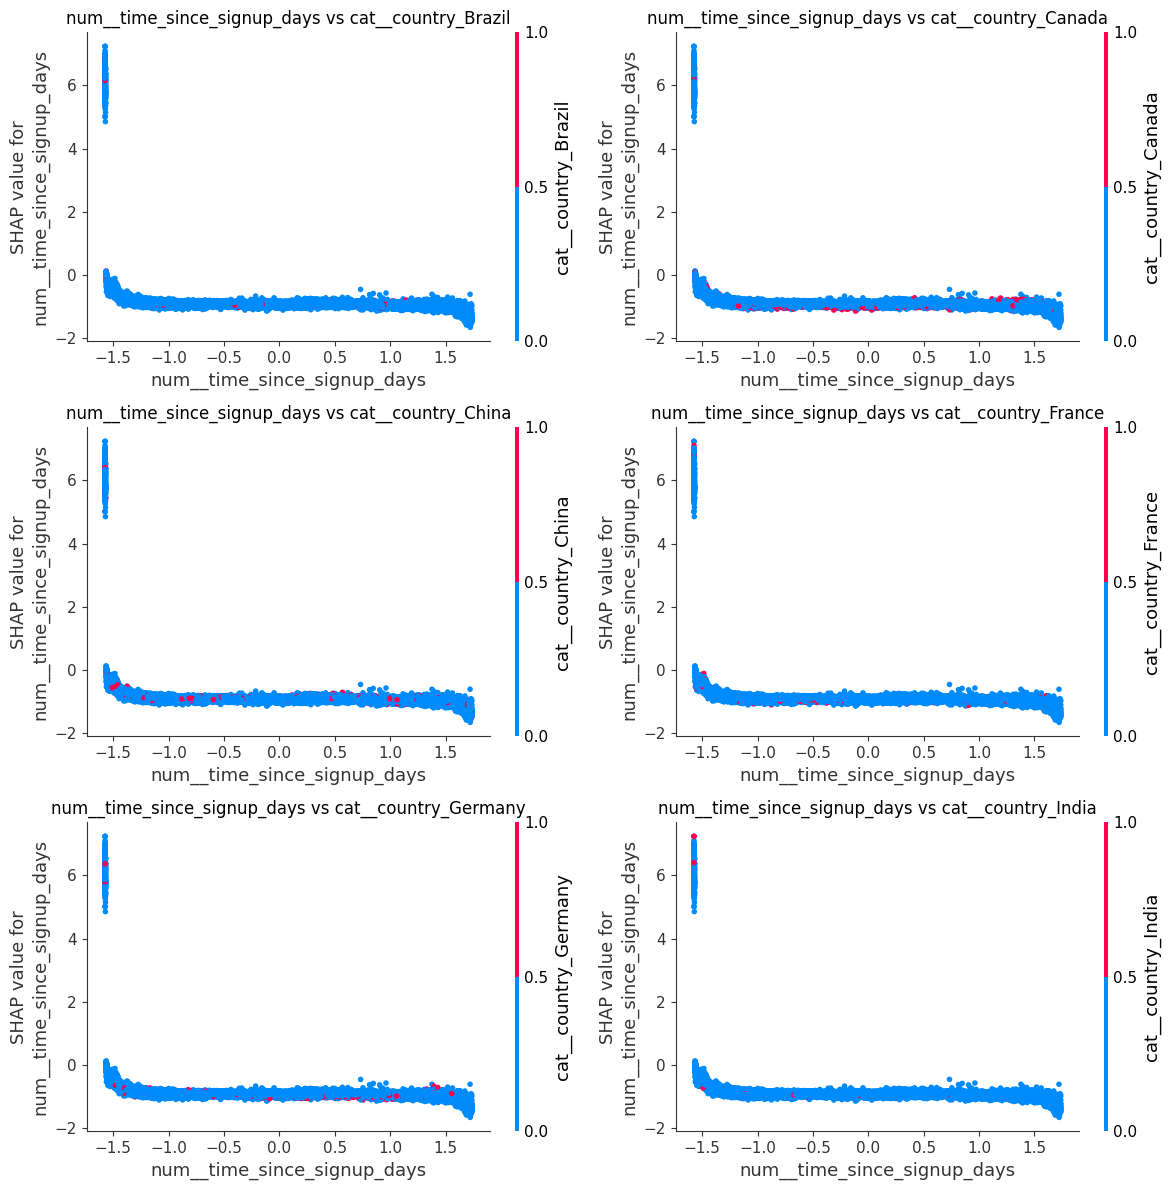

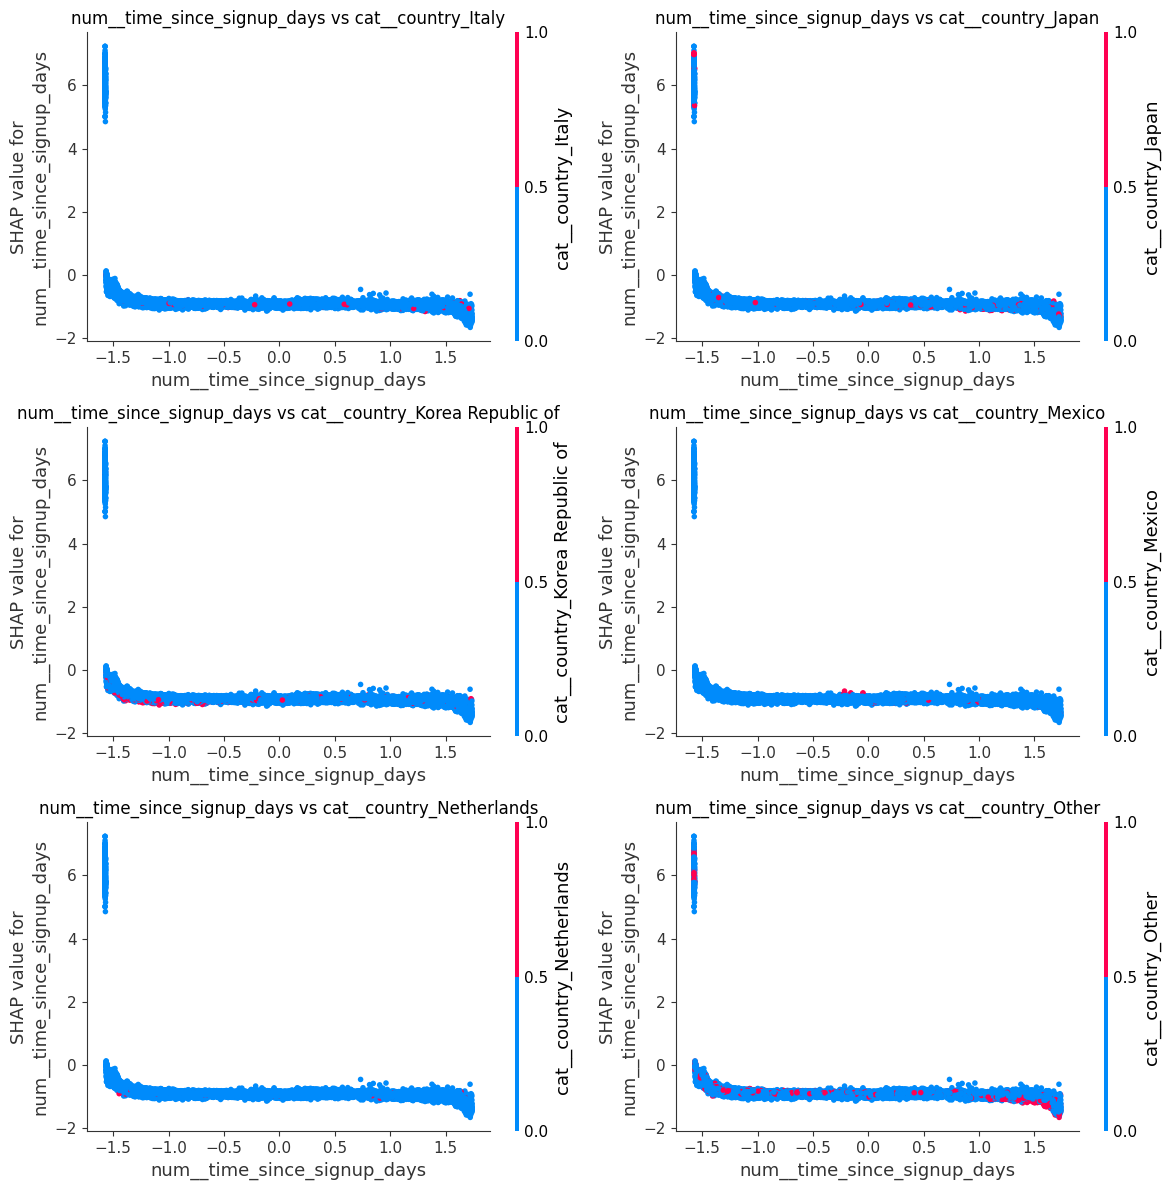

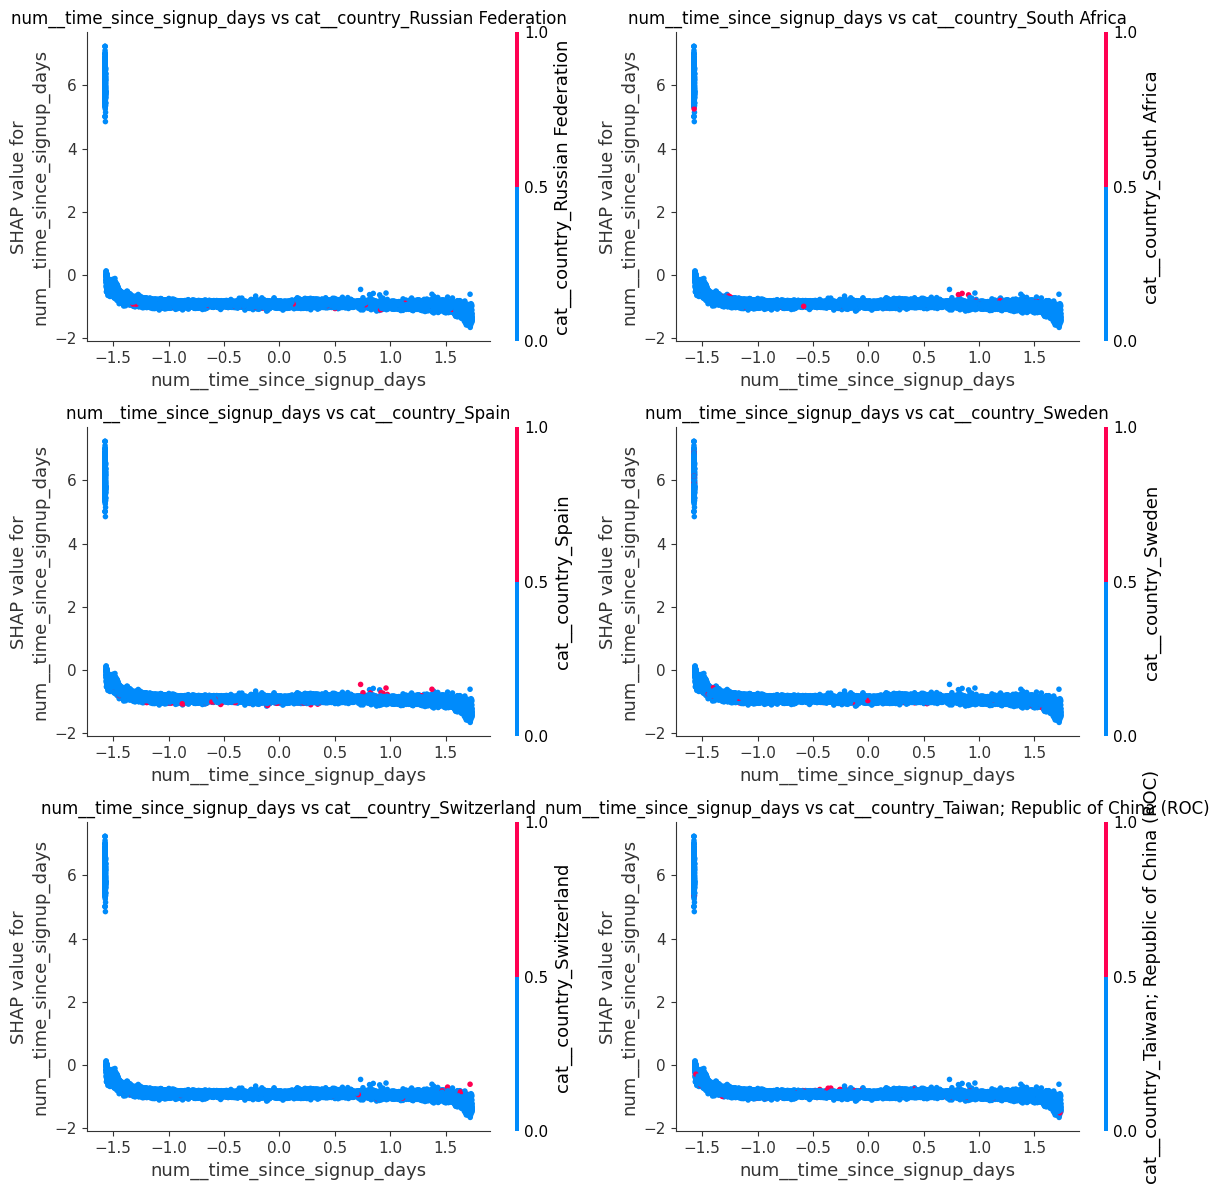

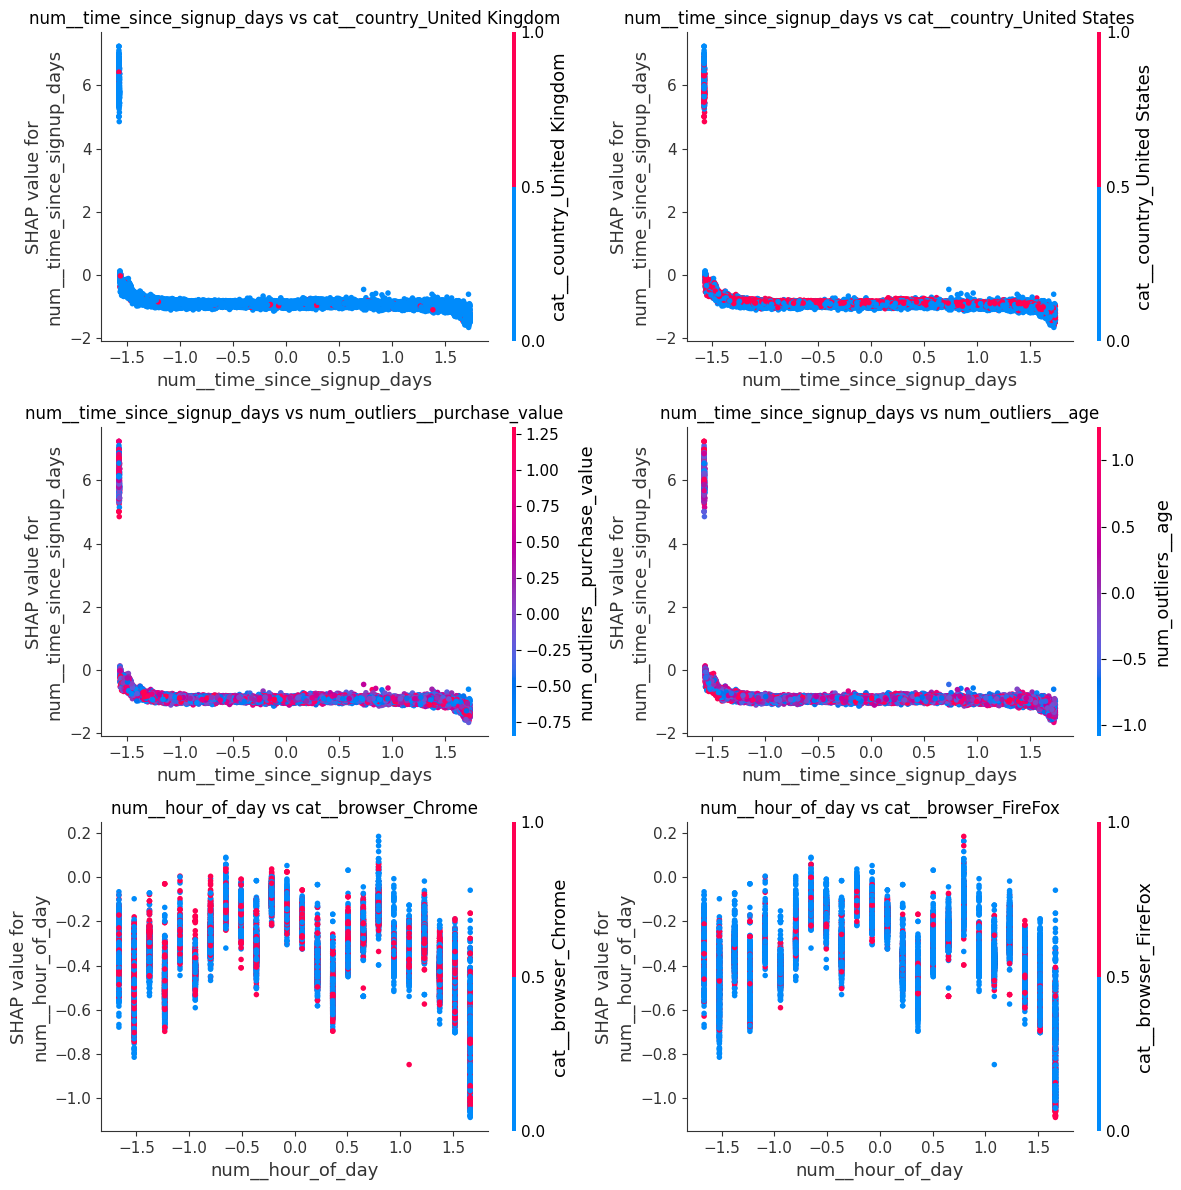

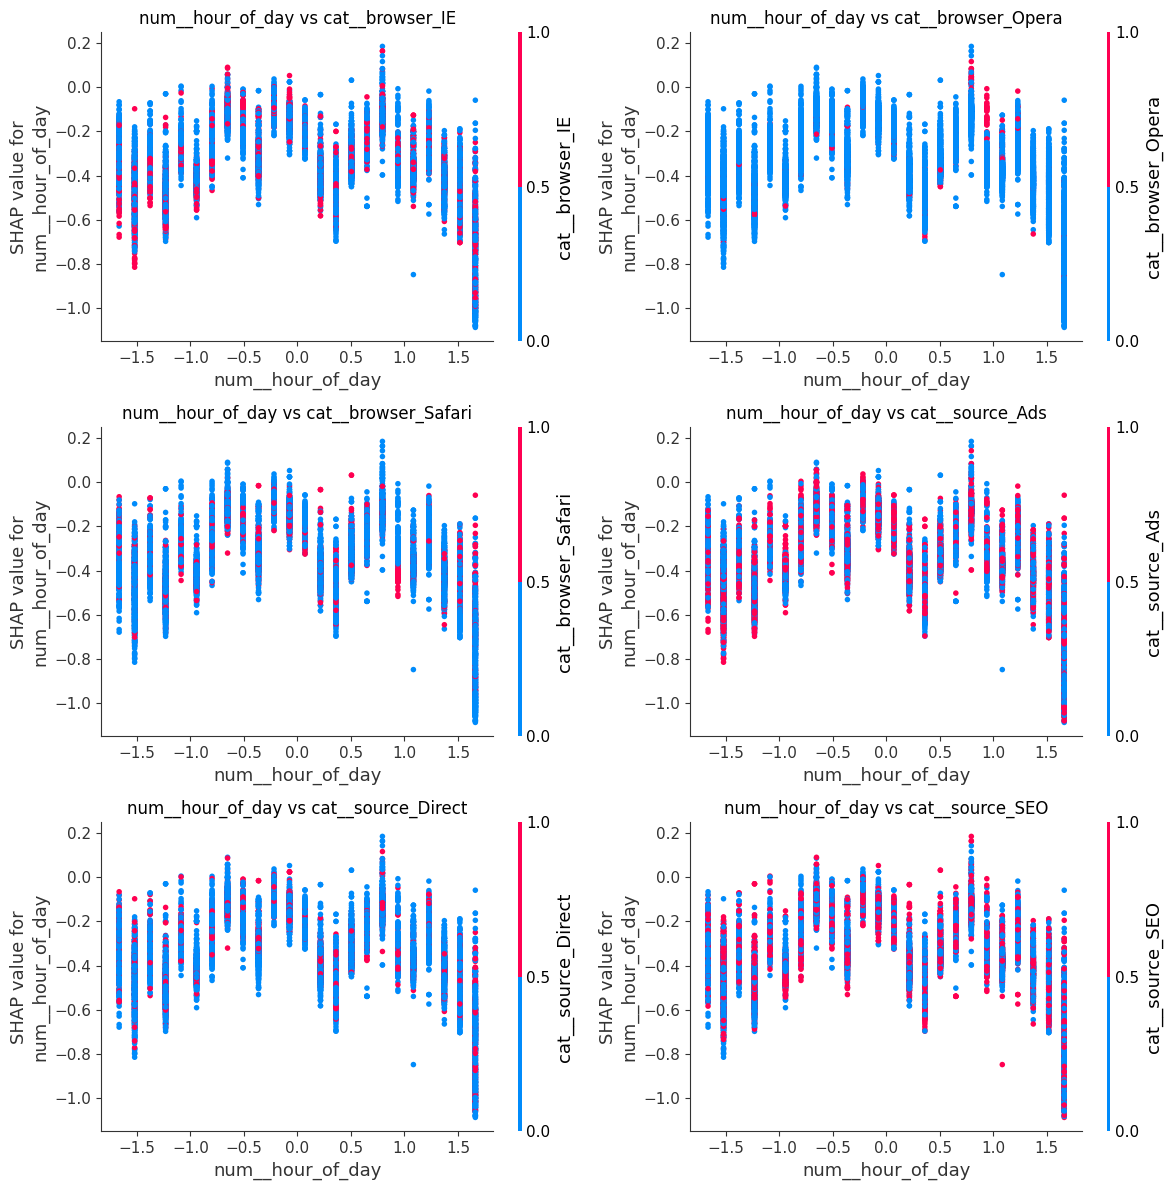

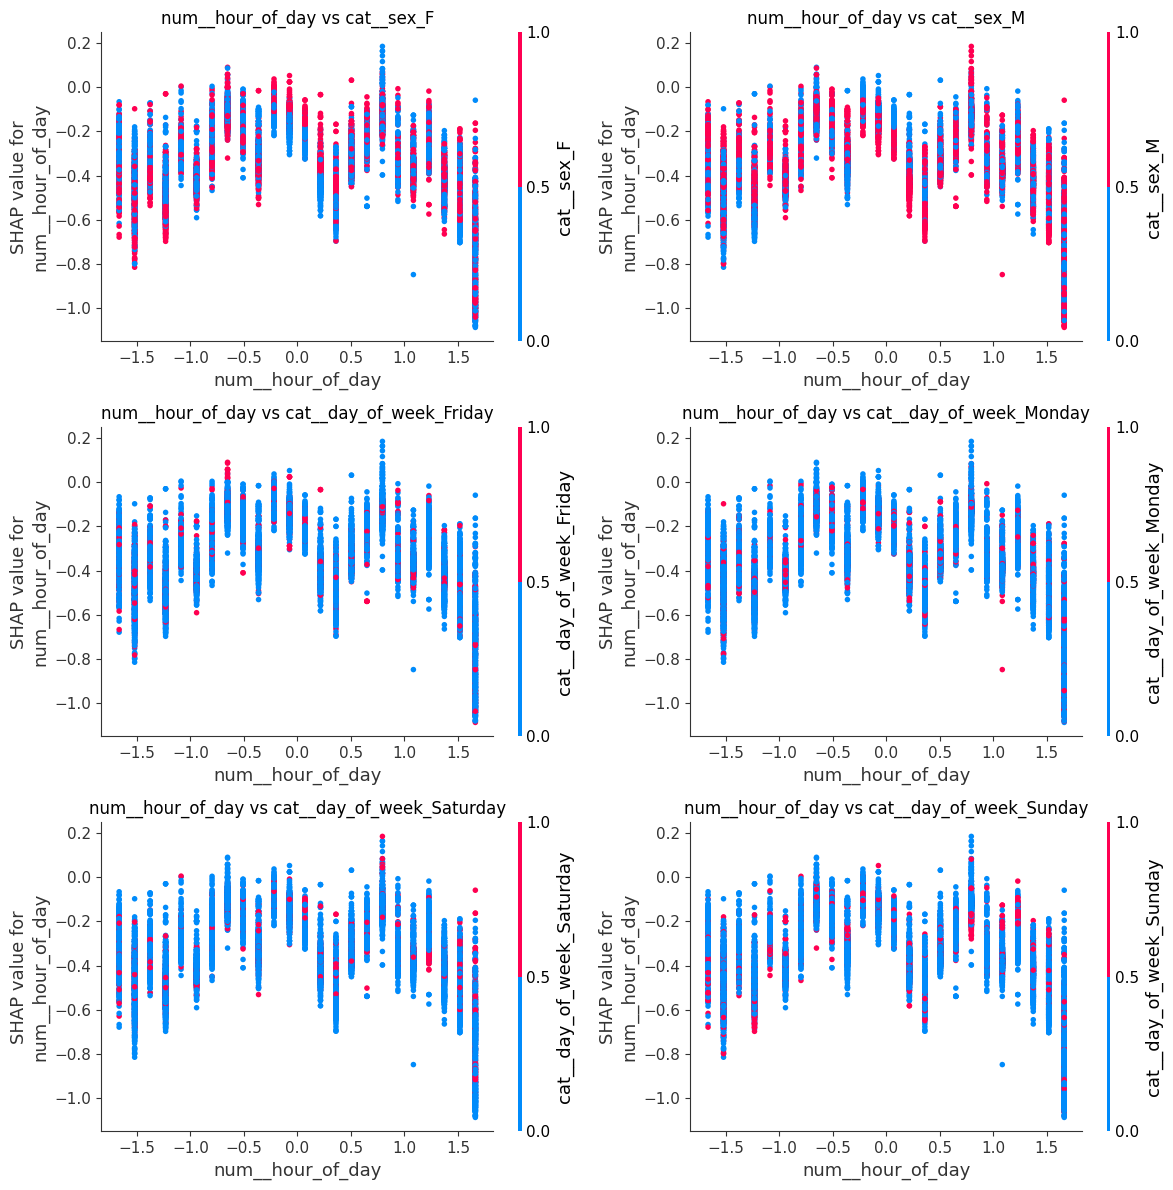

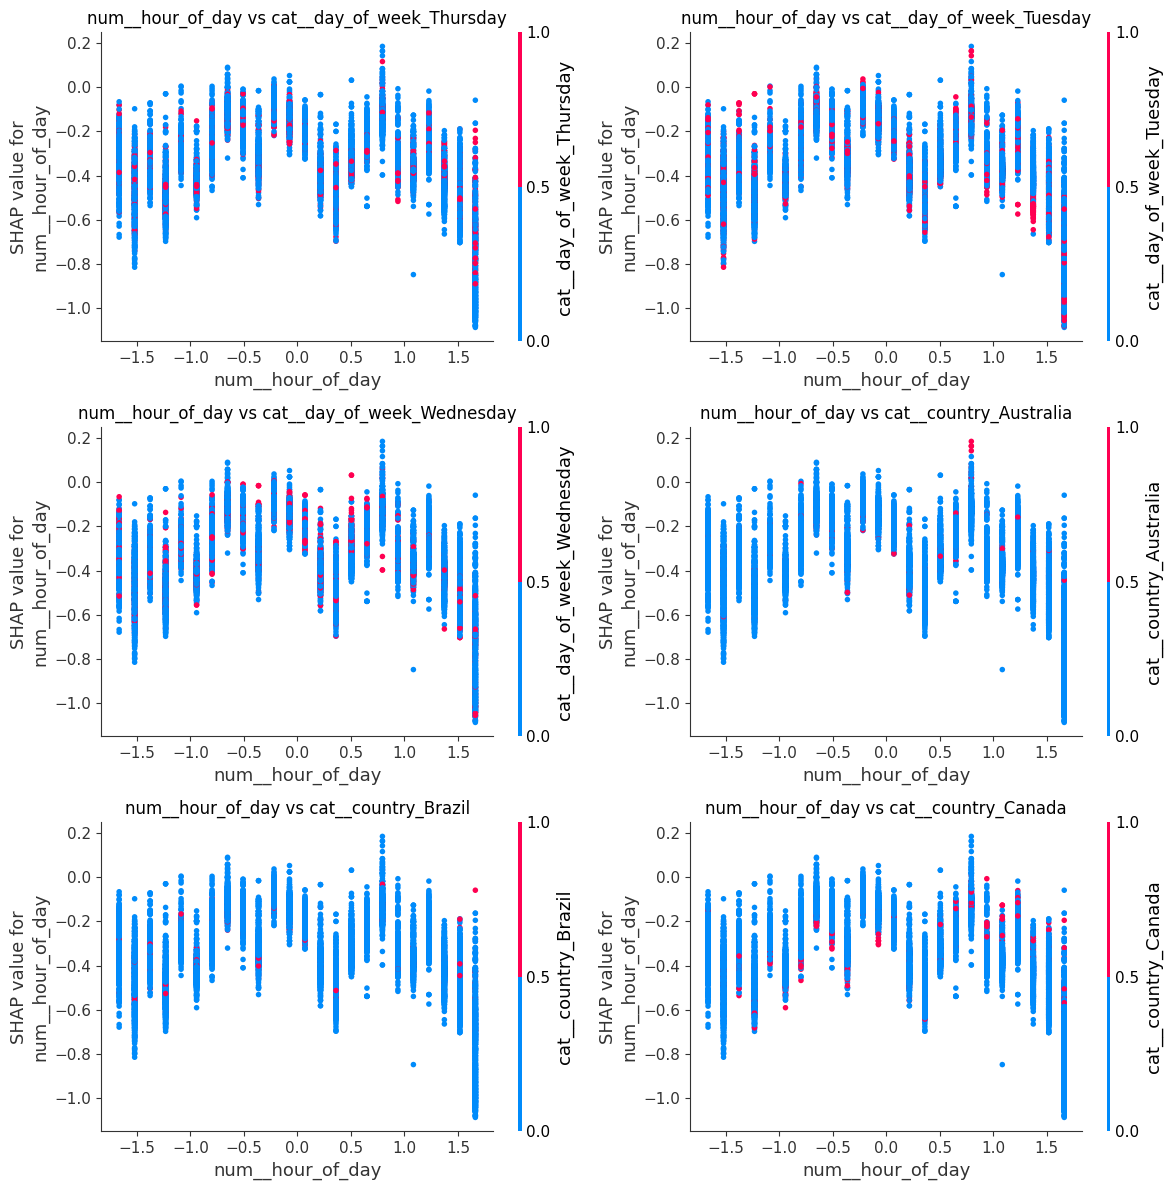

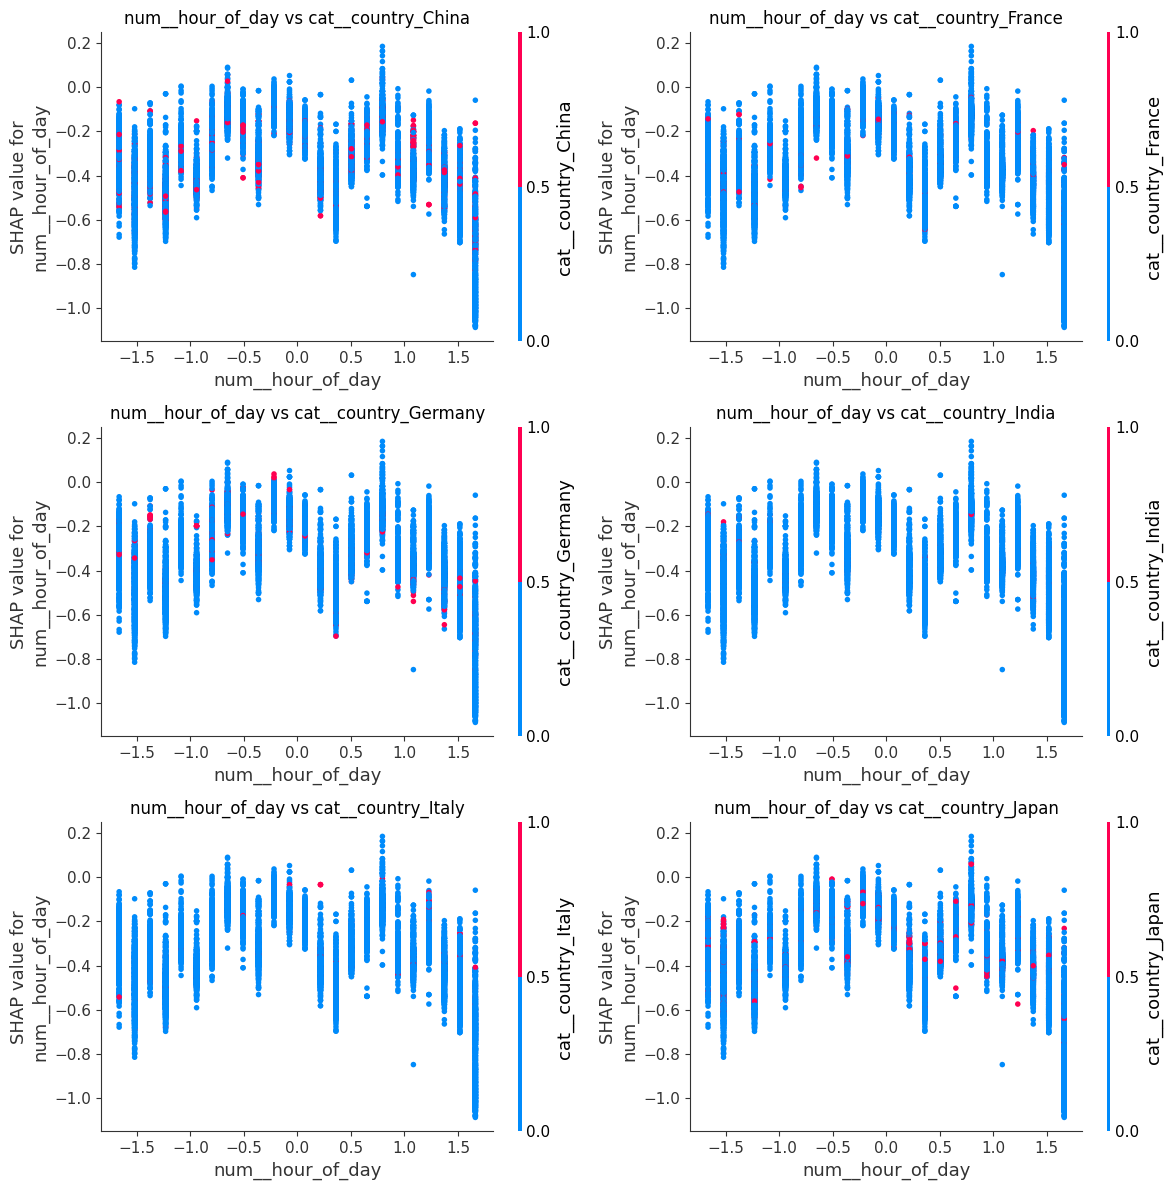

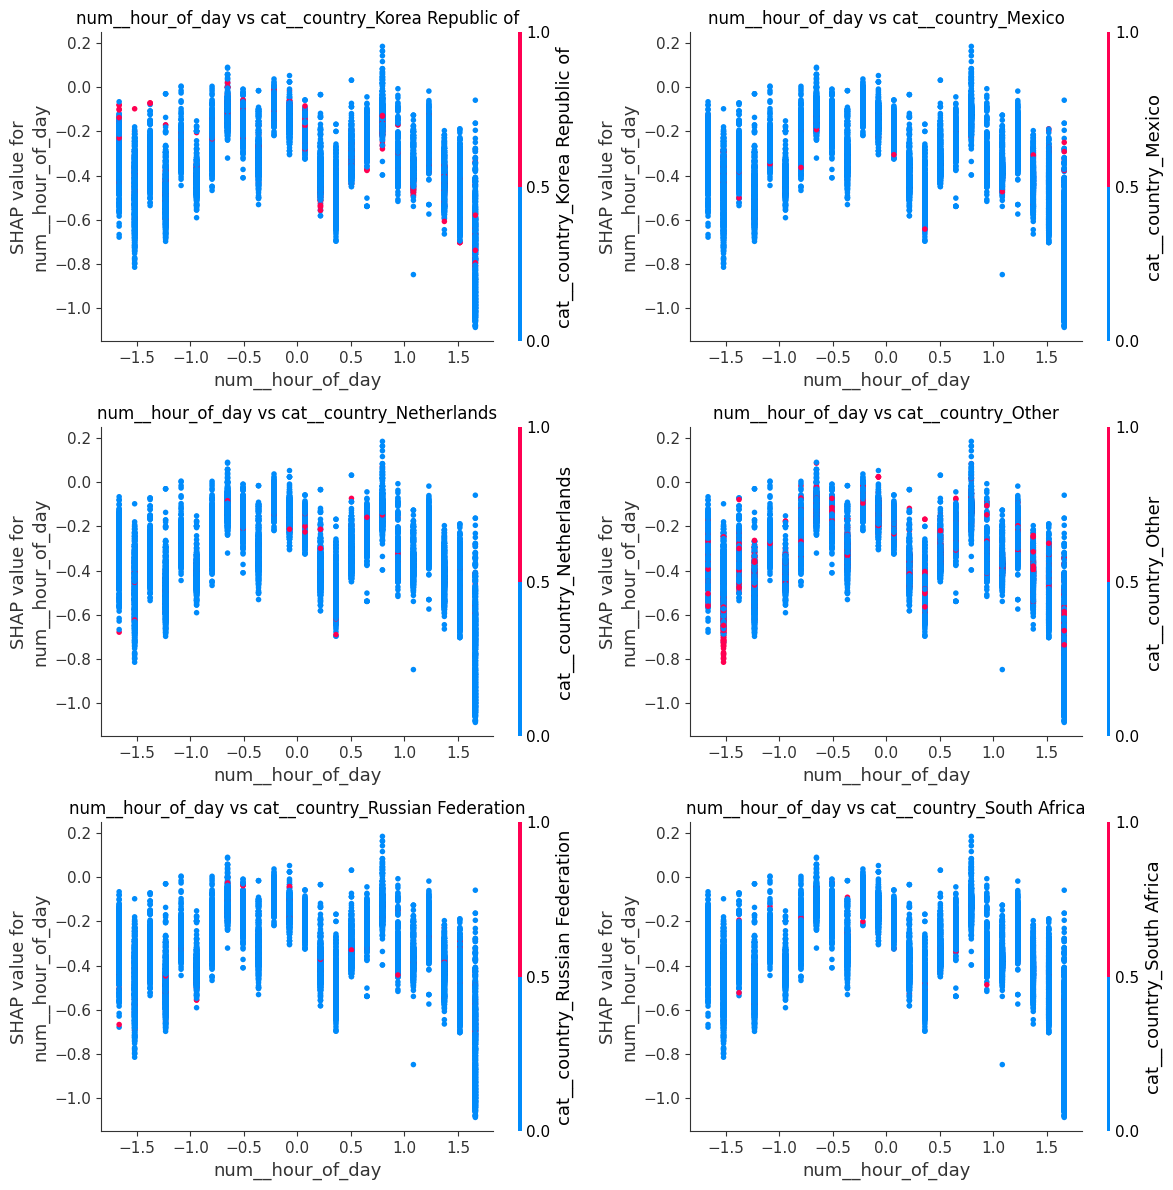

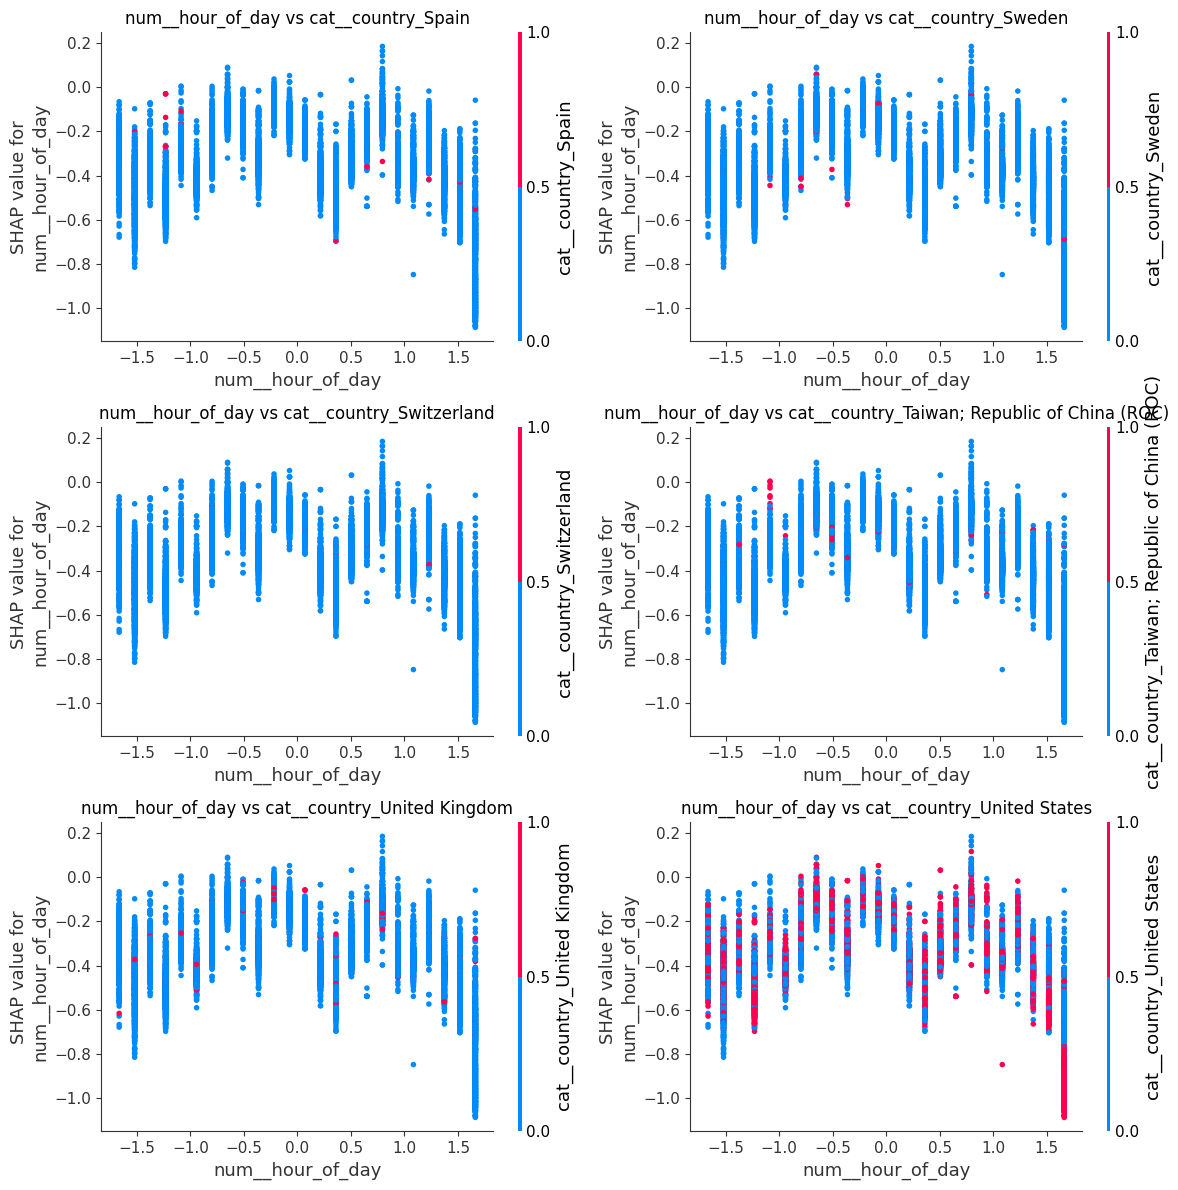

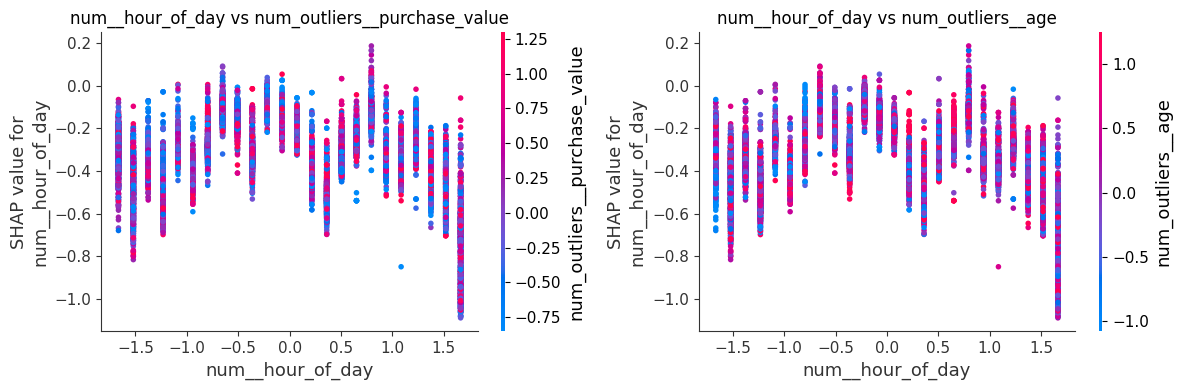

In [17]:
top_features = ["num__time_since_signup_days", "num__hour_of_day"]

# Interaction features corresponding to top features (not repeating the top feature itself)
interaction_features = ['cat__browser_Chrome', 'cat__browser_FireFox', 'cat__browser_IE', 'cat__browser_Opera', 'cat__browser_Safari', 'cat__source_Ads', 'cat__source_Direct', 'cat__source_SEO', 'cat__sex_F', 'cat__sex_M', 'cat__day_of_week_Friday', 'cat__day_of_week_Monday', 'cat__day_of_week_Saturday', 'cat__day_of_week_Sunday', 'cat__day_of_week_Thursday', 'cat__day_of_week_Tuesday', 'cat__day_of_week_Wednesday', 'cat__country_Australia', 'cat__country_Brazil', 'cat__country_Canada', 'cat__country_China', 'cat__country_France', 'cat__country_Germany', 'cat__country_India', 'cat__country_Italy', 'cat__country_Japan', 'cat__country_Korea Republic of', 'cat__country_Mexico', 'cat__country_Netherlands', 'cat__country_Other', 'cat__country_Russian Federation', 'cat__country_South Africa', 'cat__country_Spain', 'cat__country_Sweden', 'cat__country_Switzerland', 'cat__country_Taiwan; Republic of China (ROC)', 'cat__country_United Kingdom', 'cat__country_United States', 'num_outliers__purchase_value', 'num_outliers__age']

# Flatten all combinations: top_feature × interaction_feature
plots_per_page = 6  # adjust how many plots per figure
total_plots = len(top_features) * len(interaction_features)

for i in range(0, total_plots, plots_per_page):
    # Create a page of plots
    n_plots = min(plots_per_page, total_plots - i)
    n_cols = 2
    n_rows = (n_plots + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
    axes = axes.flatten()

    for j in range(n_plots):
        top_idx = (i+j) // len(interaction_features)
        inter_idx = (i+j) % len(interaction_features)
        top_feature = top_features[top_idx]
        interaction_feature = interaction_features[inter_idx]

        # Draw SHAP dependence plot in subplot
        shap.dependence_plot(
            top_feature,
            shap_values.values,  # use .values from Explanation
            X_test,
            interaction_index=interaction_feature,
            show=False,
            ax=axes[j]
        )
        axes[j].set_title(f"{top_feature} vs {interaction_feature}")

    # Hide unused axes
    for k in range(n_plots, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

## Business Recommendations

**1. Implement Enhanced Verification for New Accounts**
*   **Recommendation:** Flag all transactions from accounts less than 24-48 hours old for mandatory, multi-factor authentication (e.g., SMS or biometric verification).
*   **SHAP Insight:** `num_time_since_signup_days` is the dominant fraud driver by a wide margin. The SHAP plot shows extremely low values (very new accounts) have a massive positive impact on fraud probability.

**2. Deploy Dynamic, Time-Based Risk Scoring**
*   **Recommendation:** Automatically increase the risk score for transactions occurring during late-night/early morning hours (e.g., 10 PM to 6 AM local time) and combine this with other signals for a layered defense.
*   **SHAP Insight:** `num_hour_of_day` is the second most important SHAP feature, with higher hours (later in the day) consistently pushing predictions toward fraud, indicating a clear temporal pattern to fraudulent activity.

**3. Investigate and Refine Gender-Based Risk Profiles**
*   **Recommendation:** Conduct a focused analysis to understand *why* user sex (`cat_sex_M` and `cat_sex_F`) appears as a top-5 predictive driver in SHAP. This could reveal underlying issues (e.g., specific marketing campaigns being targeted, or data proxy effects) that need to be addressed to ensure fair and effective risk modeling.
*   **SHAP Insight:** The high SHAP importance for gender features is a surprising, counterintuitive finding that built-in importance missed. This suggests a significant, but potentially non-causal or proxy-based, pattern exists that requires business scrutiny to prevent bias and to understand the true root cause (e.g., it may be correlating with specific product lines or signup channels).

## Credit Card Dataset

Loading the trained model

In [18]:
# Load trained model
ensemble_model = joblib.load("/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/models/Credit/xgboost.pkl")
baseline_model = joblib.load("/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/models/Credit/logistic_regression.pkl")
# Load feature names
feature_names = joblib.load("/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/models/Credit/credit_feature_names.pkl")

Print the number of features and the feature names

In [19]:
print(len(feature_names))
print(feature_names[:10])

30
['num__Amount', 'scaler__Time', 'scaler__V1', 'scaler__V2', 'scaler__V3', 'scaler__V4', 'scaler__V5', 'scaler__V6', 'scaler__V7', 'scaler__V8']


Loading the test data

In [20]:
test_df = load_data("/Users/elbethelzewdie/Downloads/fraud-detection/fraud-detection/data/processed/creditcard_preprocessed_test.csv")

In [21]:
# Prepare test data
X_test = test_df[feature_names]

y_test = test_df["class"]

Top 10 Feature Importances from XGBoost Model

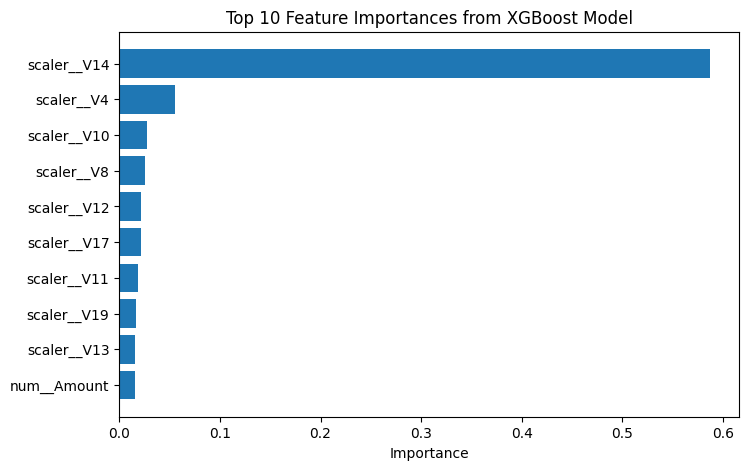

In [22]:
importances = ensemble_model.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Top 10
top10 = fi_df.head(10)

plt.figure(figsize=(8,5))
plt.barh(top10["feature"], top10["importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances from XGBoost Model")
plt.xlabel("Importance")
plt.show()

- The feature importance for this credit card dataset shows that engineered or scaled principal components (V14, V4, V10, etc.) are the dominant predictors, which is typical for anonymized transaction data. The num_Amount of the transaction is the only original, interpretable feature in the top 10, indicating that while transaction value is relevant, the hidden patterns captured by the PCA components (likely representing time, location, and merchant profiles) are far more critical for fraud detection. This suggests the model's decision-making is highly reliant on complex, latent features rather than simple, business-intuitive ones.

Top 10 Feature Importances from Logistic Regression Model

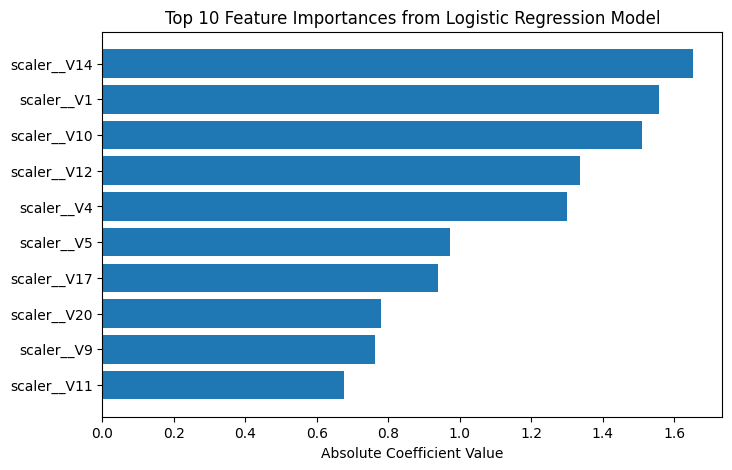

In [23]:
# coef_ is (n_classes, n_features) for binary classification
coefs = baseline_model.coef_[0]  # take first row for binary classification

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": np.abs(coefs)  # absolute value to see magnitude
}).sort_values(by="importance", ascending=False)

# Top 10
top10 = fi_df.head(10)

plt.figure(figsize=(8,5))
plt.barh(top10["feature"], top10["importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances from Logistic Regression Model")
plt.xlabel("Absolute Coefficient Value")
plt.show()

- This Logistic Regression model also relies overwhelmingly on the scaled principal components (scaler_V14, scaler_V1, etc.), mirroring the XGBoost results. The coefficients are on a much larger scale than XGBoost's importance scores, which is characteristic of linear models but makes direct magnitude comparison difficult. Notably, num_Amount is absent from its top 10, indicating that for the linear model, the latent patterns in the 'V'-features completely overshadow the raw transaction amount as a linear predictor. This highlights that fraud signals in this dataset are deeply embedded within the engineered features, not in simple, standalone numeric values.

SHAP Explanation for Model Predictions

In [24]:
explainer = shap.TreeExplainer(ensemble_model)
shap_values = explainer(X_test)

Visualization

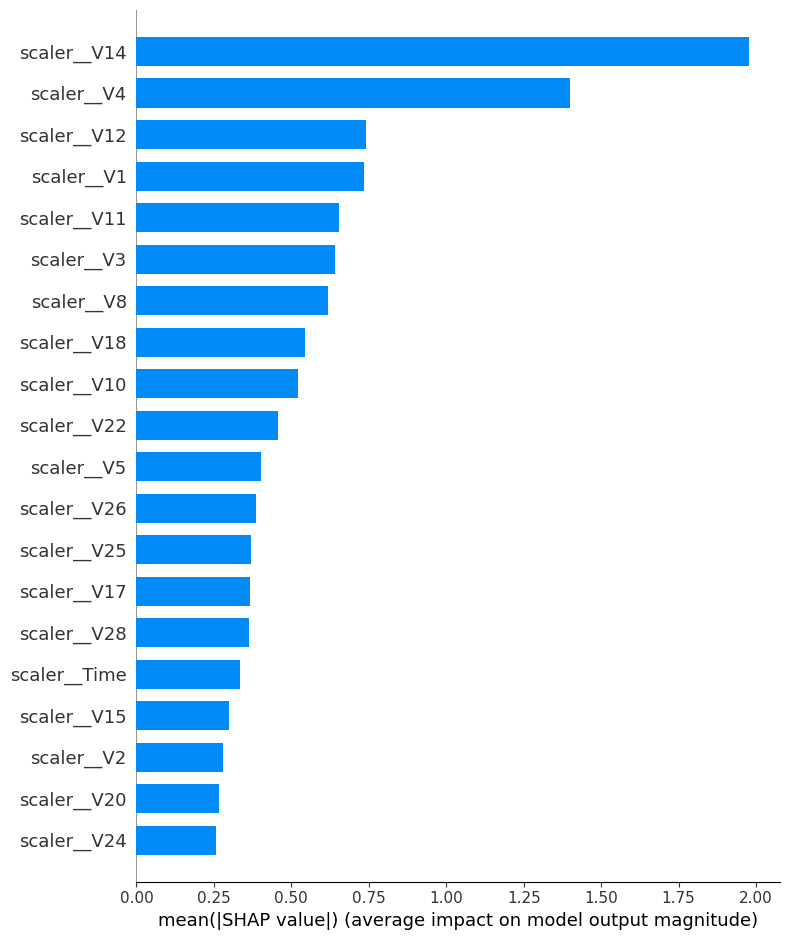

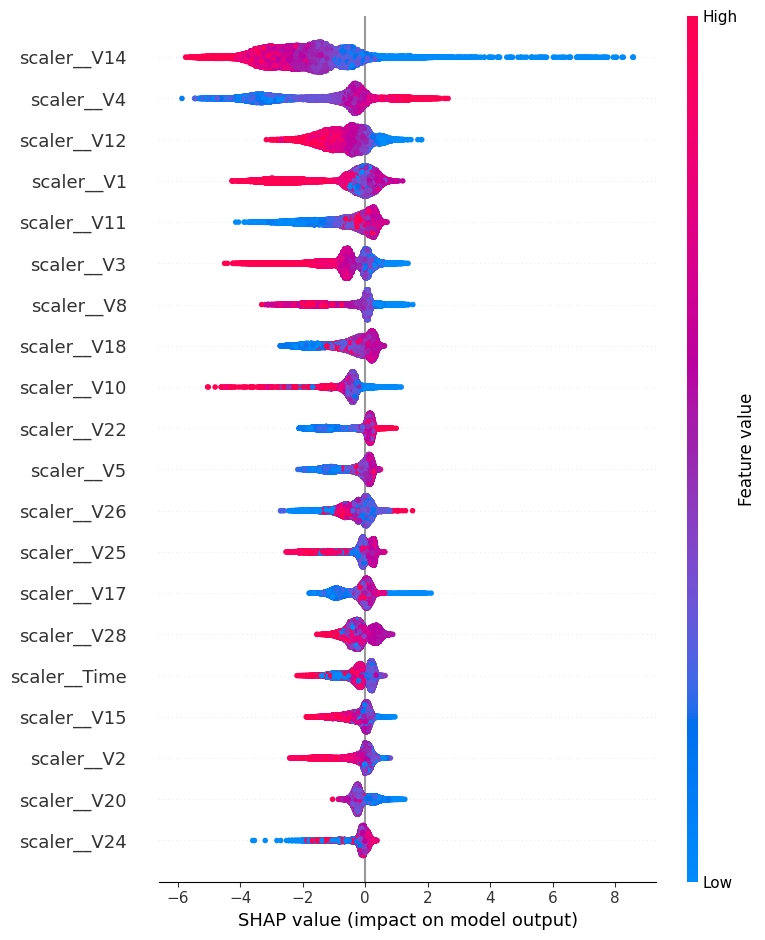

In [25]:
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

- This SHAP summary plot confirms that scaler_V14 is the most influential feature, with extreme negative values strongly pushing the model toward a fraud prediction (positive SHAP values). Several other V-features (V4, V12, V1) show a similar bipolar impact, where both very high and very low values can signal fraud, revealing complex, non-linear relationships. The scaler_Time feature's wide spread indicates transaction timing is a significant, nuanced risk factor. The plot underscores that fraud detection relies on a network of subtle, interacting anomalies within the principal components rather than a single, straightforward rule.



Predicting Fraud on the Test Set

In [26]:
y_pred = ensemble_model.predict(X_test)


Identifying True Positives, False Positives, and False Negatives

In [27]:
# True positives (fraud correctly predicted)
tp_idx = np.where((y_test==1) & (y_pred==1))[0][0]

# False positives (legit flagged as fraud)
fp_idx = np.where((y_test==0) & (y_pred==1))[0][0]

# False negatives (fraud missed)
fn_idx = np.where((y_test==1) & (y_pred==0))[0][0]


### SHAP Force Plot for a True Positive, False Positive and False Negative

In [28]:
# For Jupyter Notebook
shap.initjs()

# True positive
shap.force_plot(explainer.expected_value, shap_values[tp_idx].values, X_test.iloc[tp_idx])


- This true positive fraud case was correctly identified due to extreme negative anomalies in key features like scaler_V14, scaler_V12, and scaler_V17, which are the strongest fraud signals according to the SHAP analysis. The combined negative deviations across multiple principal components created a definitive, high-risk profile that the model accurately captured.

In [29]:
# False positive
shap.force_plot(explainer.expected_value, shap_values[fp_idx].values, X_test.iloc[fp_idx])

- This false positive was likely triggered because scaler_V14 was moderately negative (-0.7), a key fraud indicator, while several other features (V4, V10, V5) showed unusually high positive values. The model interpreted this specific combination of a negative V14 with multiple elevated positive features as a high-risk anomaly, even though it was legitimate.

In [30]:
# False negative
shap.force_plot(explainer.expected_value, shap_values[fn_idx].values, X_test.iloc[fn_idx])

- This is a clear miss: scaler_V14 is extremely negative (-4.466), the strongest possible fraud signal. However, the unusually high positive value of scaler_V4 (3.267) likely created a conflicting pattern that pulled the overall prediction toward a non-fraudulent class, causing the model to incorrectly overlook the critical V14 anomaly.

Mean absolute SHAP value per feature

In [31]:
# Mean absolute SHAP value per feature
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='shap_importance', ascending=False)

top5_shap = shap_importance.head(5)
print("Top 5 SHAP features driving fraud predictions:")
print(top5_shap)

Top 5 SHAP features driving fraud predictions:
        feature  shap_importance
15  scaler__V14         1.978463
5    scaler__V4         1.398384
13  scaler__V12         0.740084
2    scaler__V1         0.734187
12  scaler__V11         0.653177


Top 5 Built-in Feature Importance

In [32]:
top5_builtin = fi_df.head(5)
print("Top 5 built-in feature importance:")
print(top5_builtin)

Top 5 built-in feature importance:
        feature  importance
15  scaler__V14    1.652567
2    scaler__V1    1.556991
11  scaler__V10    1.509477
13  scaler__V12    1.335952
5    scaler__V4    1.300336


- Both methods unanimously identify scaler_V14 as the number one fraud driver, confirming it is the primary signal. The top 5 are largely the same set of PCA features (V14, V4, V12, V1) in both lists, showing strong agreement on the core latent risk dimensions.

- The key difference is the high rank of scaler_V11 in SHAP (5th) versus its absence from the built-in top 5, where scaler_V10 appears instead. This indicates that while V10 is globally important for splitting the data (built-in), V11 has a more substantial and consistent causal impact on shifting individual predictions toward fraud (SHAP). This reveals that V11's specific value is a more direct lever for fraud probability in real transactions.

#### SHAP Dependence Plots for Top Features vs. Multiple Interaction Features

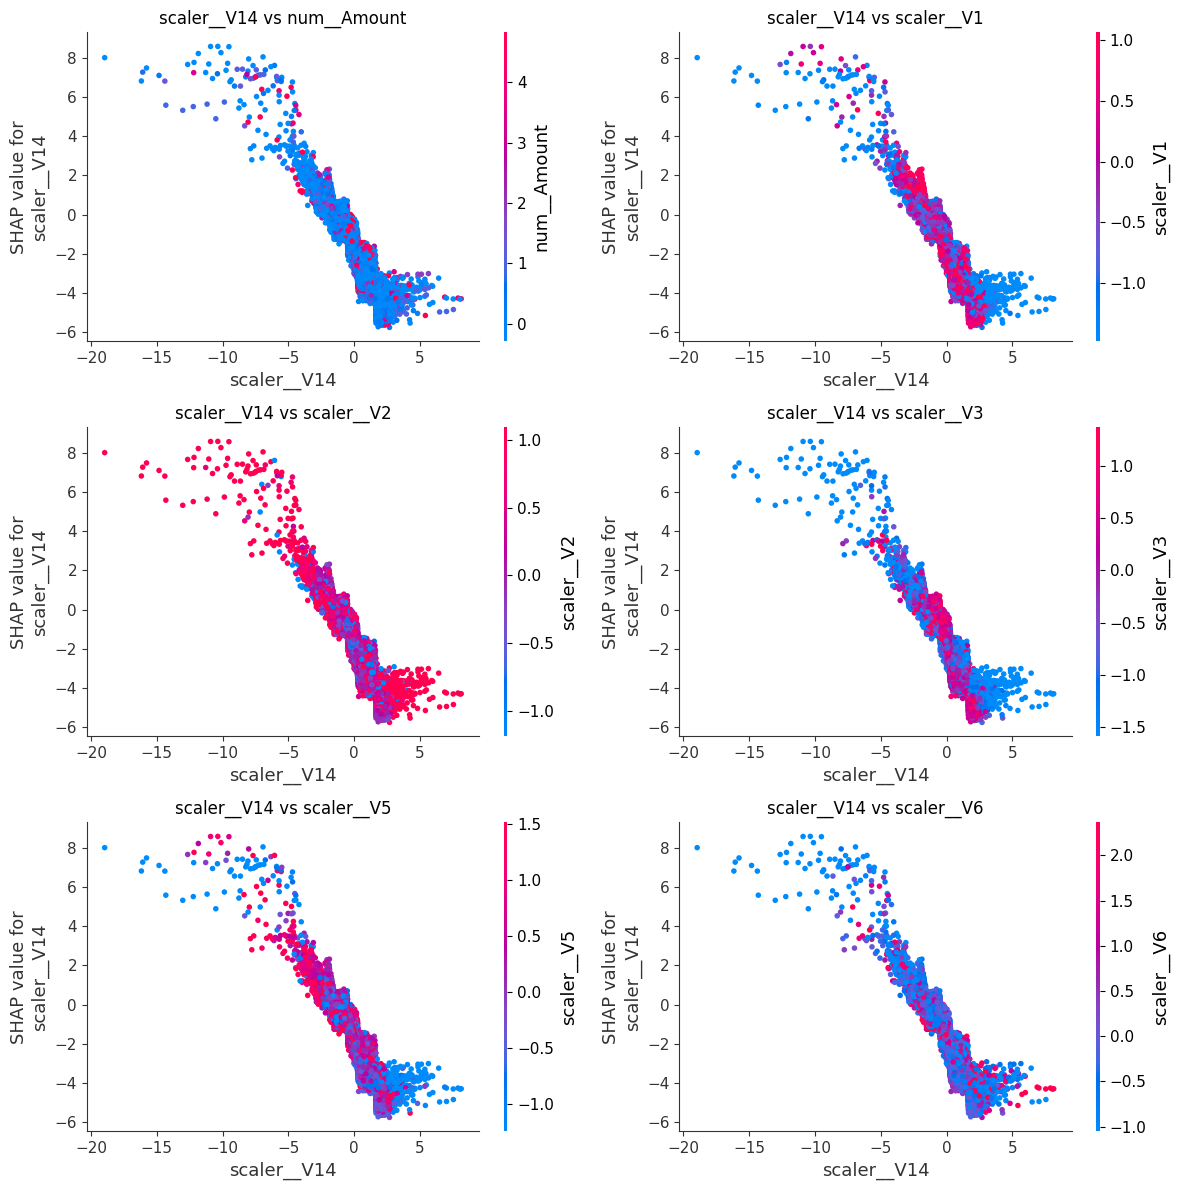

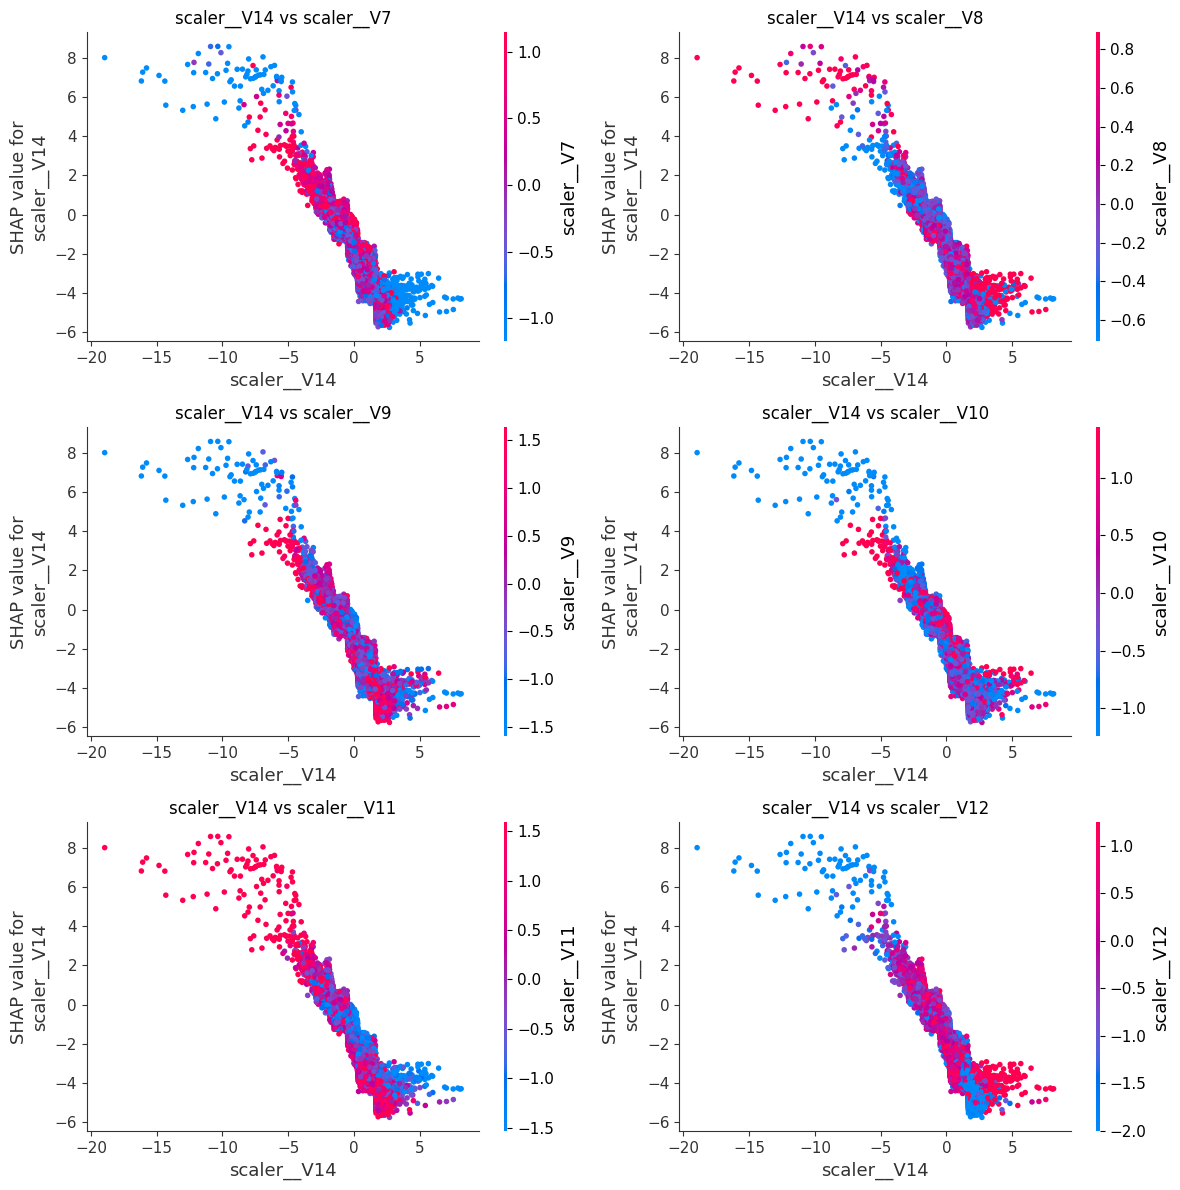

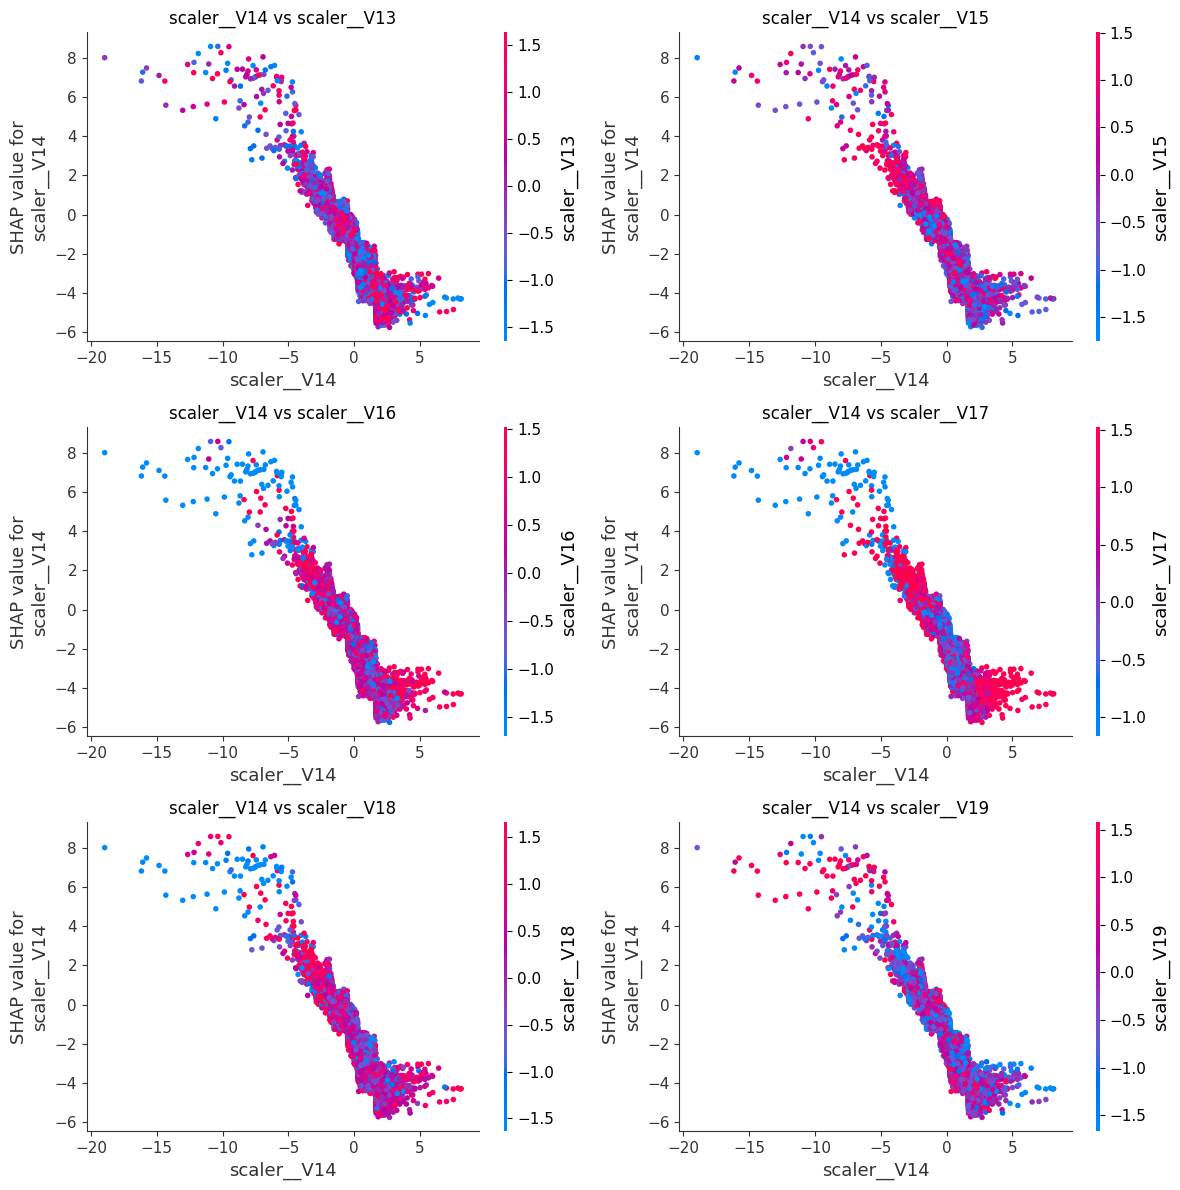

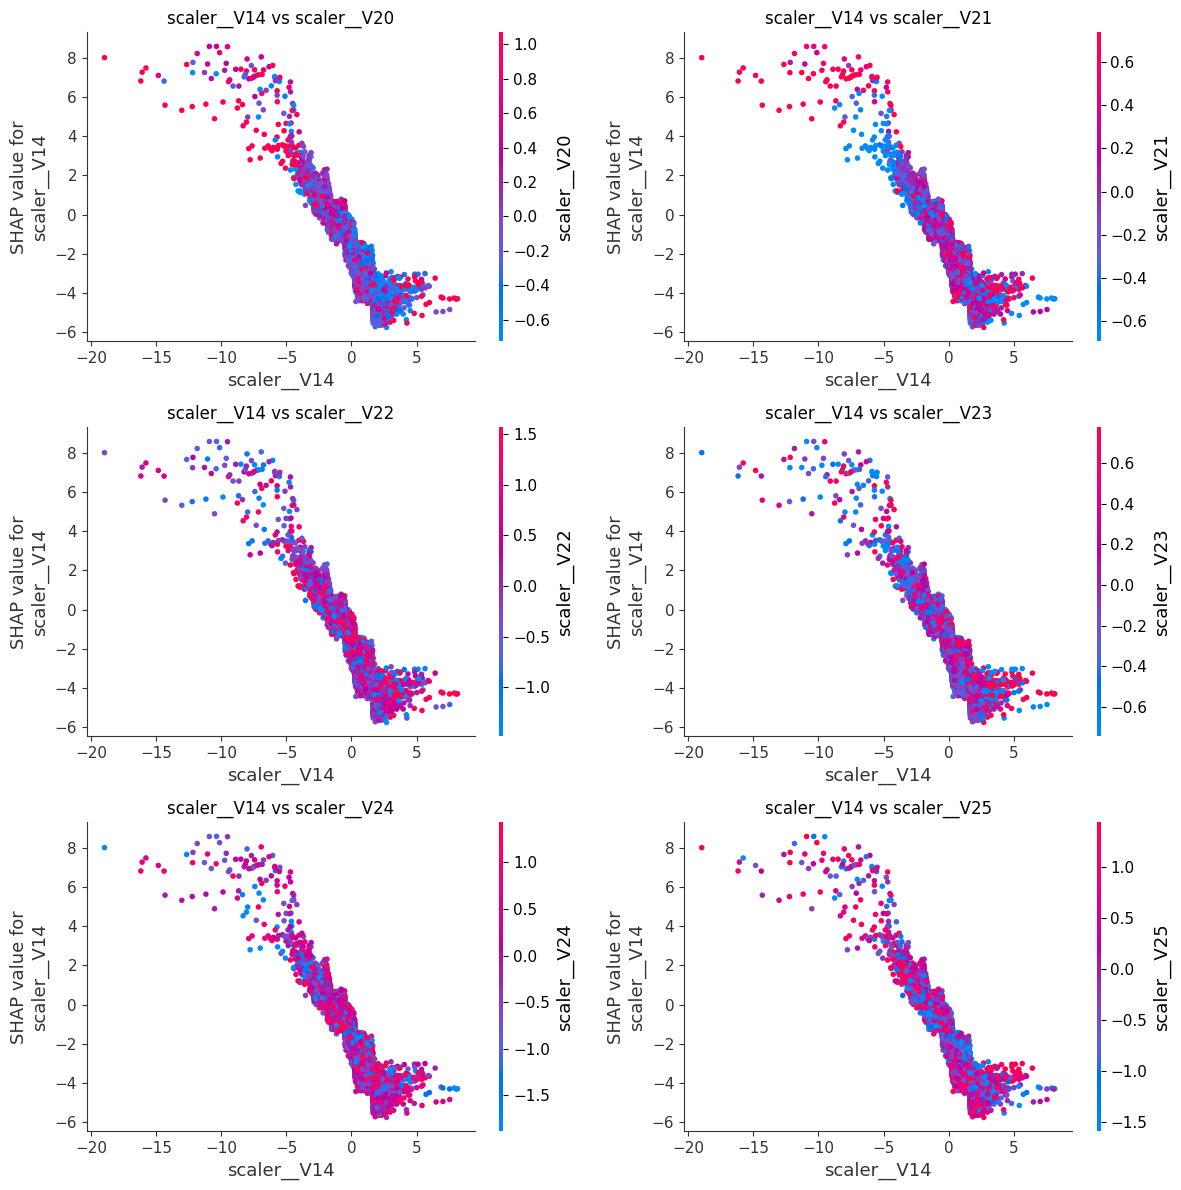

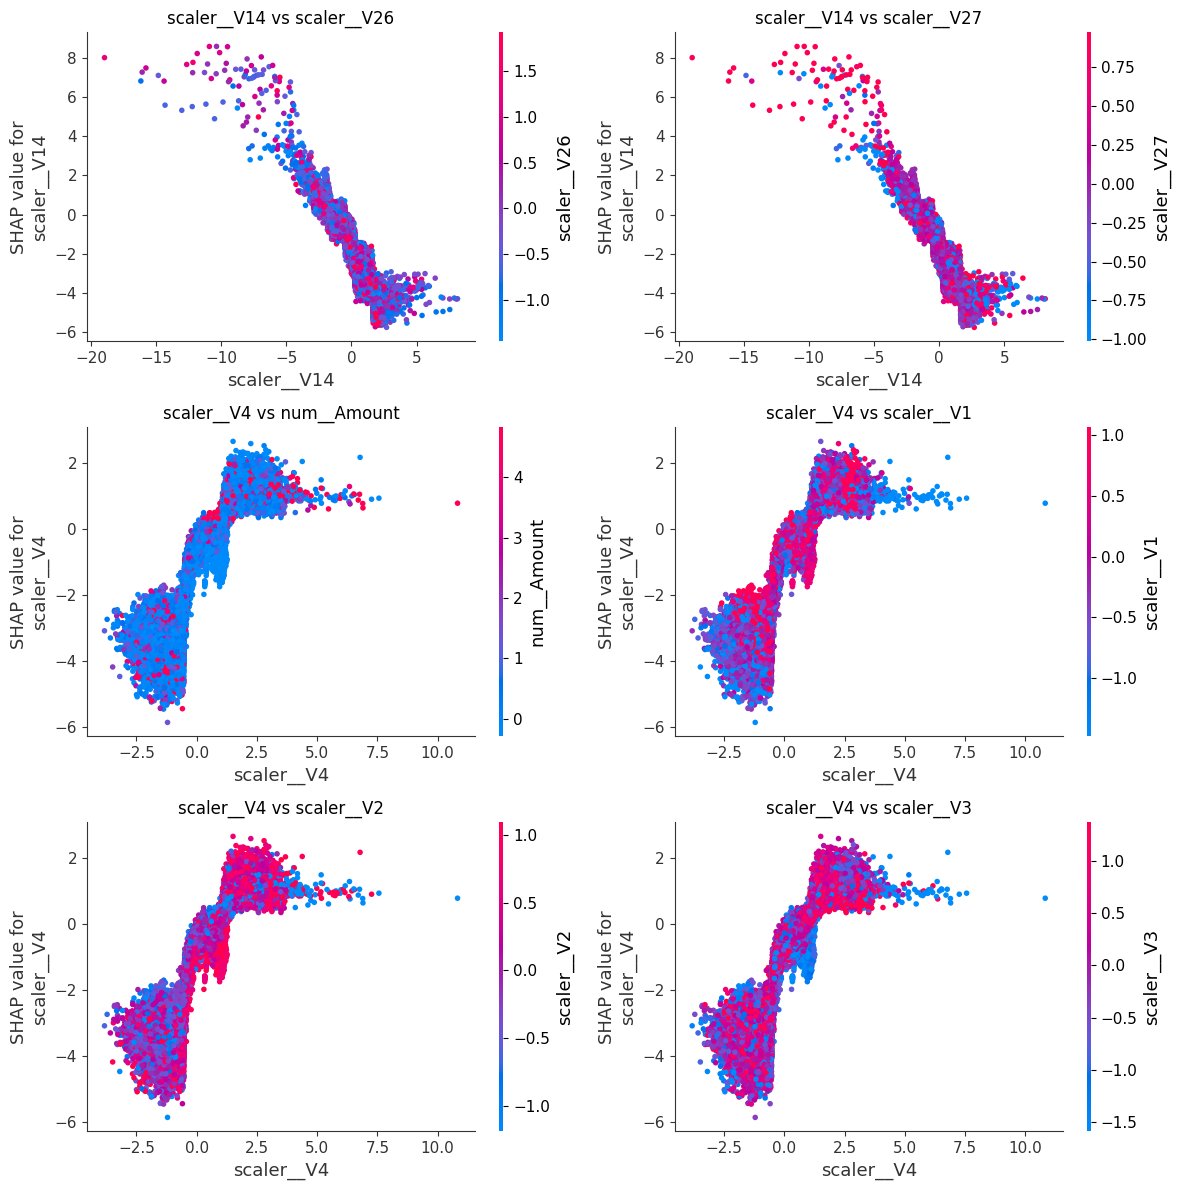

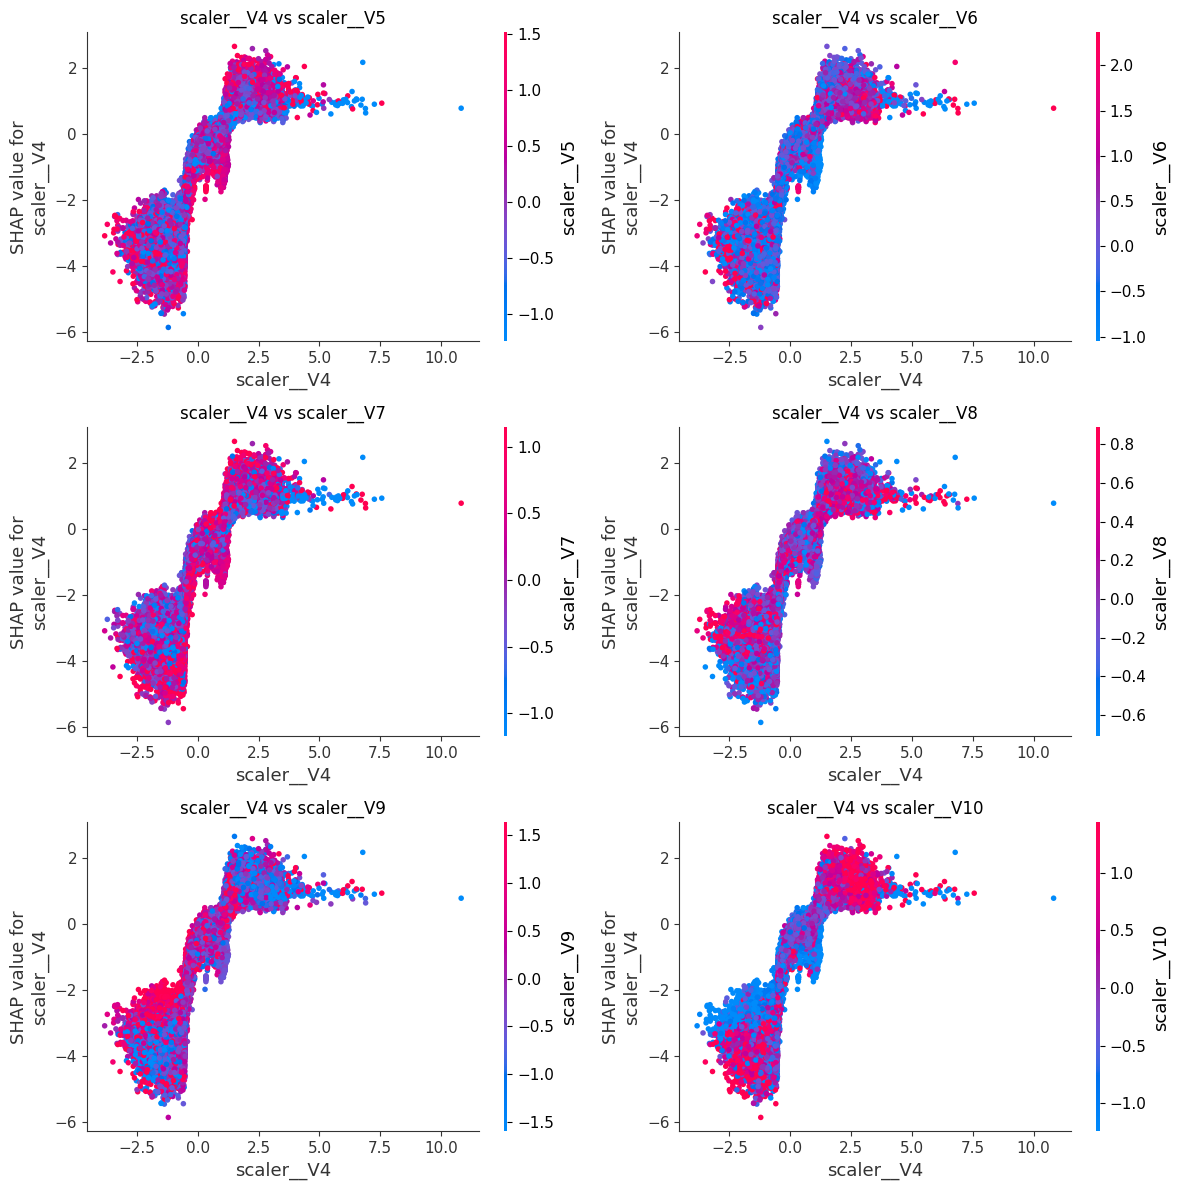

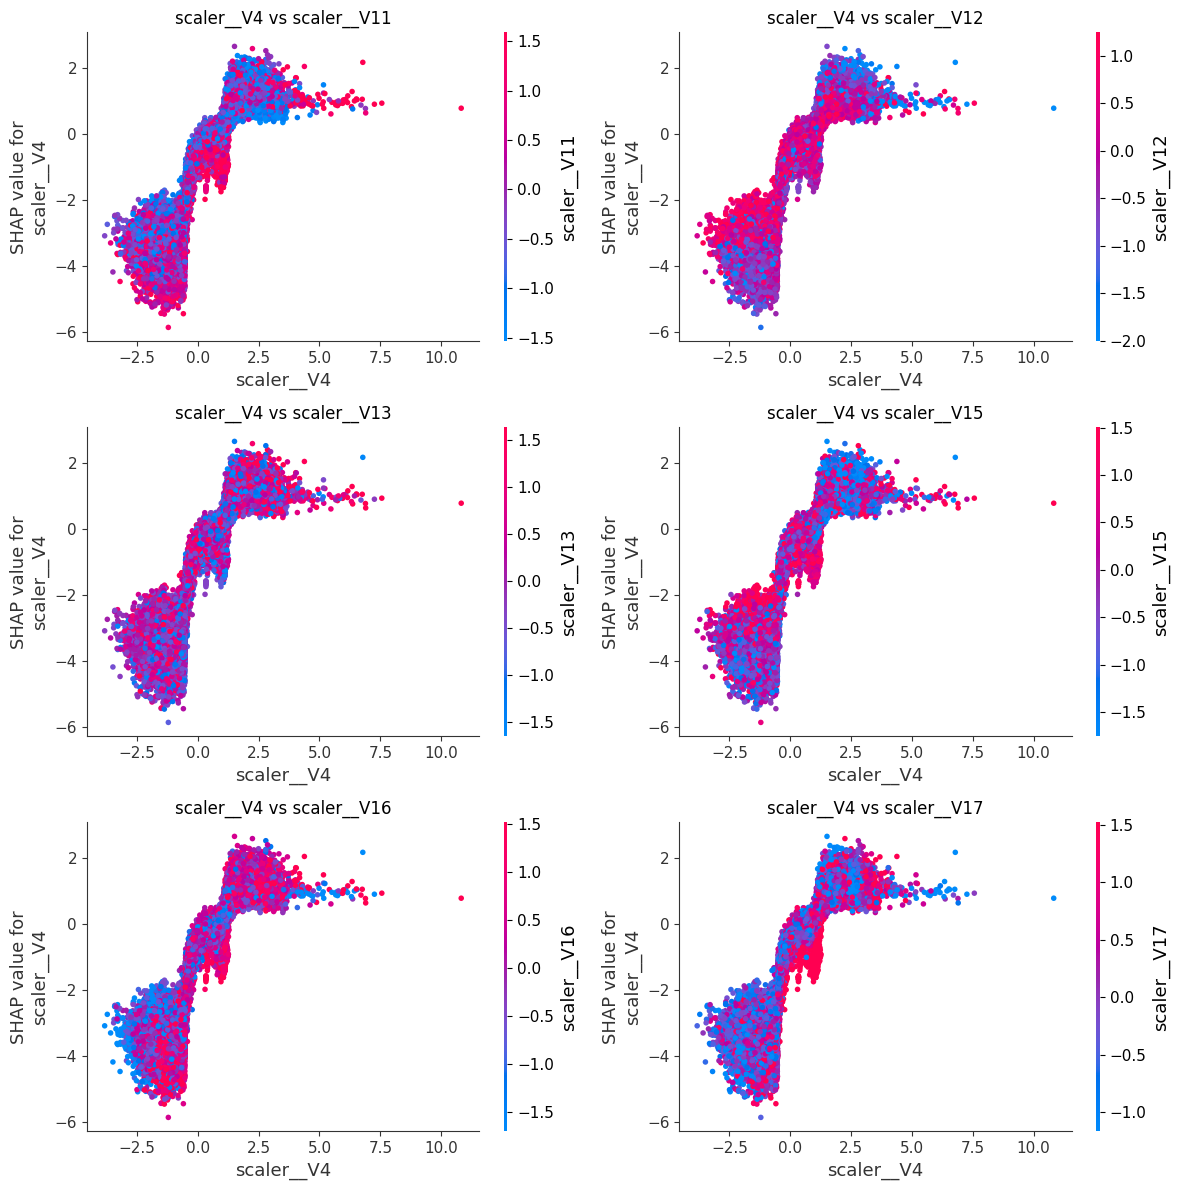

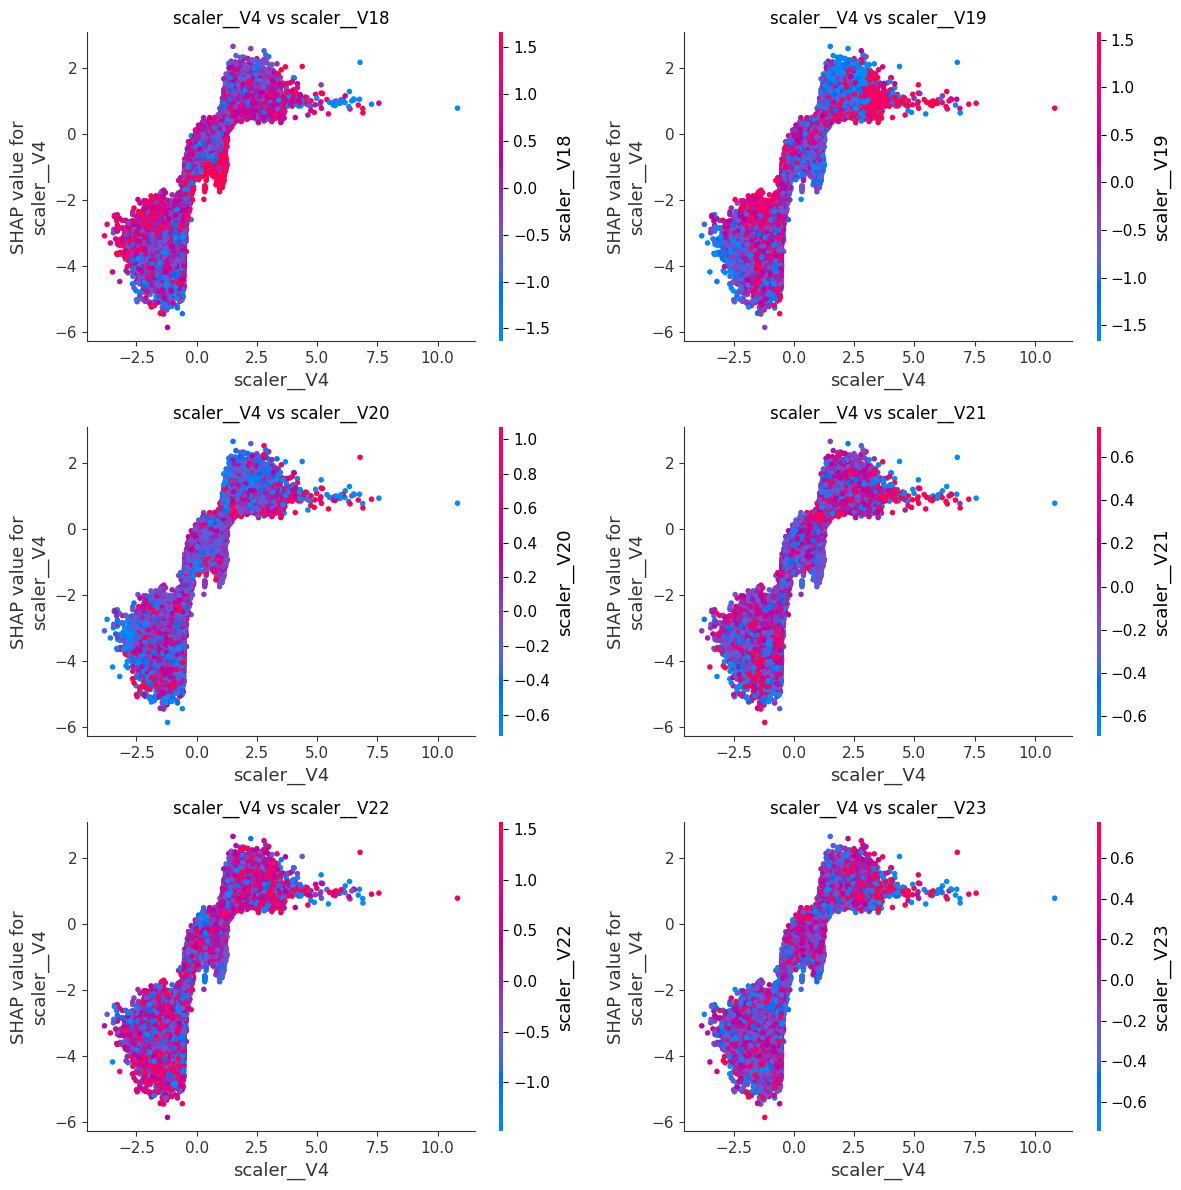

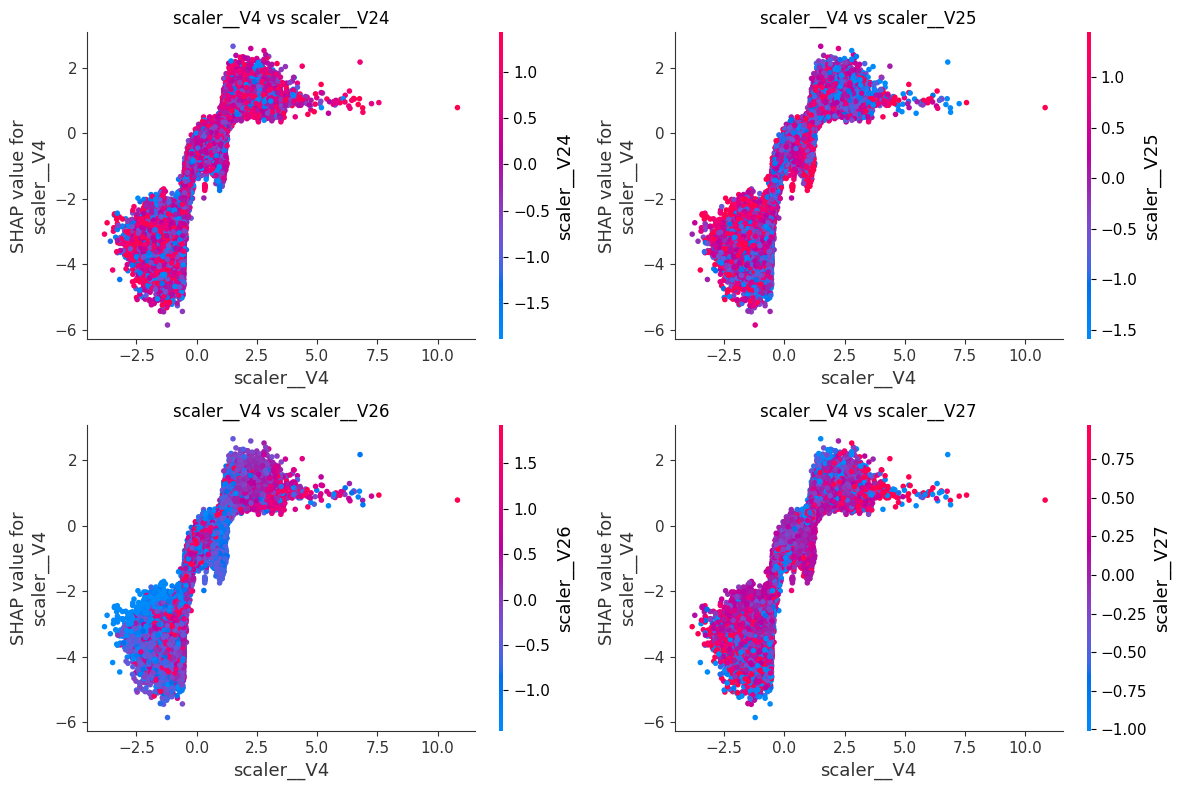

In [33]:
top_features = ["scaler__V14", "scaler__V4"]

# Interaction features corresponding to top features (not repeating the top feature itself)
interaction_features = ["num__Amount", "scaler__V1", "scaler__V2", "scaler__V3", "scaler__V5", "scaler__V6", "scaler__V7", "scaler__V8", "scaler__V9", "scaler__V10", "scaler__V11", "scaler__V12", "scaler__V13", "scaler__V15", "scaler__V16", "scaler__V17", "scaler__V18", "scaler__V19", "scaler__V20", "scaler__V21", "scaler__V22", "scaler__V23", "scaler__V24", "scaler__V25", "scaler__V26", "scaler__V27"]

# Flatten all combinations: top_feature × interaction_feature
plots_per_page = 6  # adjust how many plots per figure
total_plots = len(top_features) * len(interaction_features)

for i in range(0, total_plots, plots_per_page):
    # Create a page of plots
    n_plots = min(plots_per_page, total_plots - i)
    n_cols = 2
    n_rows = (n_plots + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
    axes = axes.flatten()

    for j in range(n_plots):
        top_idx = (i+j) // len(interaction_features)
        inter_idx = (i+j) % len(interaction_features)
        top_feature = top_features[top_idx]
        interaction_feature = interaction_features[inter_idx]

        # Draw SHAP dependence plot in subplot
        shap.dependence_plot(
            top_feature,
            shap_values.values,  # use .values from Explanation
            X_test,
            interaction_index=interaction_feature,
            show=False,
            ax=axes[j]
        )
        axes[j].set_title(f"{top_feature} vs {interaction_feature}")

    # Hide unused axes
    for k in range(n_plots, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

## Business Recommendations

**1. Implement a Hard Rule-Based Alert for Extreme V14 Values**
*   **Recommendation:** Establish an automated rule to flag and manually review any transaction where the `scaler_V14` feature falls below a specific negative threshold (e.g., -3.5), regardless of the model's final score.
*   **SHAP Insight:** `scaler_V14` is the dominant fraud driver. The SHAP plot and case reviews show extreme negative values are almost exclusively associated with fraud (true positives and false negatives), representing a near-certain risk signal.

**2. Develop a Secondary Review Queue for Conflicting Signal Patterns**
*   **Recommendation:** Create a dedicated review queue for transactions where a strongly negative `V14` coincides with strongly positive values in other key features like `V4` or `V10`.
*   **SHAP Insight:** The false negative analysis revealed that a powerfully negative `V14` can be "overruled" by opposing signals (e.g., a high `V4`), causing misses. This specific conflict pattern requires human expert judgment to resolve.

**3. Prioritize Model Monitoring and Investigation on Feature V11**
*   **Recommendation:** Allocate data science resources to deeply analyze the underlying transaction attributes that drive the `V11` principal component, as SHAP indicates it is a critical, underrated fraud lever.
*   **SHAP Insight:** `scaler_V11` ranks 5th in SHAP importance but is absent from the model's own top 5 built-in importance. This discrepancy signals it is a highly influential yet potentially misunderstood feature; understanding its real-world meaning could unlock more precise detection rules or feature engineering.